# Evaluation of multi-omics GRN inference methods
## Preprocessing perturbation and multiomics data
### by Jalil Nourisa

# <a id='toc2_'></a>[Imports](#toc0_)

In [2]:
import scipy

import os, binascii
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata as ad
# import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

import rpy2.robjects as ro
import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})
colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']


sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.pandas2ri.activate()

%load_ext rpy2.ipython

main_dir = '../'
work_dir = f'{main_dir}/output'

out_edger_dir= f'{work_dir}/de_analysis/edger'
out_limma_dir= f'{work_dir}/de_analysis/limma'


kaggle_dir = '../input/kaggle/input/open-problems-single-cell-perturbations'
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
train_cell_types =  ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']

T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_types_major = ['T cells', 'NK cells', 'B cells', 'Myeloid cells']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}


outliers_me = np.asarray(['AT13387', 'Alvocidib', 'BMS-387032', 'CEP-18770 (Delanzomib)',
       'CGM-097', 'CGP 60474', 'Ganetespib (STA-9090)', 'I-BET151',
       'IN1451', 'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)',
       'Proscillaridin A;Proscillaridin-A', 'Resminostat',
       'UNII-BXU45ZH6LI', 'Vorinostat'])
train_sm_names = np.asarray(['Idelalisib', 'Crizotinib', 'Linagliptin', 'Palbociclib',
       'Alvocidib', 'LDN 193189', 'R428',
       'Porcn Inhibitor III', 'Foretinib', 'MLN 2238',
       'Penfluridol', 'Dactolisib', 'O-Demethylated Adapalene',
       'Oprozomib (ONX 0912)', 'CHIR-99021'])

negative_control = 'Dimethyl Sulfoxide'

from matplotlib.patches import Patch
# the stacked bar code is adopted from Ambrosm
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, xticklabels=None, colors=None, figsize=(25, 4), ax=None, legend=False):
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i in range(len(cell_types)):
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=colors_cell_type[i])
    ax.set_title(title)
    # first_legend = ax.legend(title='Cell Types')
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        Patch(facecolor='red', label='-'),
        Patch(facecolor='blue', label='-'),
        Patch(facecolor='green', label='-'),
    ]

    
    return fig, ax

 
def generate_colors(num_colors):
    np.random.seed(30)  # For reproducibility
    colors = np.random.rand(num_colors, 3)  # Generate colors in RGB format
    return colors

# Generate 150 distinct colors
colors_list = generate_colors(150)

def isolation_forest(df_subset, group=['index']):
    from sklearn.ensemble import IsolationForest
    cell_count_m = df_subset.pivot(index=group, columns='cell_type', values='cell_count')
    cell_count_ratio = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
    cell_count_ratio = cell_count_ratio.fillna(0)
    clf = IsolationForest(max_samples=100, random_state=0)
    clf.fit(cell_count_ratio.values)
    outlier_compounds = cell_count_ratio.index[clf.predict(cell_count_ratio.values)==-1]
    return outlier_compounds

def plot_scatter(obs, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    n_axes = len(obs_index)
    fig, axes = plt.subplots(n_axes, 1, figsize=figsize, sharey=False)
    alpha = .2
    edgecolors = 'white'
    for i_index, index in enumerate(obs_index):
        # i = i_index // n_axes
        j = i_index % n_axes
        ax = axes[j]

        index_vars = obs[index]
        
        if index=='sm_name':
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=alpha, color='cyan', edgecolors=edgecolors)
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=alpha, color='blue', edgecolors=edgecolors)
            
        else:
            included_vars = index_vars.unique()
            colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']
            for i, var in enumerate(included_vars):
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=alpha, edgecolors=edgecolors, color=colors[i])
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
    return fig, axes


# EDA on pseudobulked data

In [3]:
de_tag = 'tcells_filter3' #tcells_filter3, 'tcells_filter1', 'tcells'
adata_tag = 'complete_tcells_filter3'# 'complete_tcells'

In [47]:
# sc_counts = ad.read_h5ad(f'../input/sc_counts.h5ad')
sc_counts

AnnData object with n_obs × n_vars = 301785 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

In [8]:

bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_{adata_tag}.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
bulk_adata.var = bulk_adata.var.rename(columns={'index':'gene'})
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2159 × 12766
    obs: 'plate_well_cell_type', 'plate_name', 'positive_ctr', 'cell_type', 'timepoint_hr', 'dose_uM', 'row', 'container_format', 'hashtag_id', 'well', 'split', 'donor_id', 'raw_cell_id', 'col', 'sm_name', 'cell_id', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'sum', 'std'

In [244]:
bulk_adata.obs.cell_type.unique()

['B cells', 'Myeloid cells', 'NK cells', 'T cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

In [245]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.21145432292862779


In [246]:
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']
bulk_adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]), columns=bulk_adata.var.index)
sum_count = bulk_adata.X.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(bulk_adata_df)

bulk_adata_df.head()

index                                                             A1BG  \
sm_name               cell_type     plate_name row donor_id              
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    5.667065   
                      Myeloid cells 010        A   Donor 1    4.048687   
                      NK cells      010        A   Donor 1    5.636244   
                      T cells       010        A   Donor 1   26.450145   
MK-5108               B cells       010        A   Donor 1   15.882003   

index                                                         A1BG-AS1  \
sm_name               cell_type     plate_name row donor_id              
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   25.116704   
                      Myeloid cells 010        A   Donor 1   37.259095   
                      NK cells      010        A   Donor 1   15.596035   
                      T cells       010        A   Donor 1   60.032780   
MK-5108               B cells       010        A   Donor 1   46.297878   

index                                                               A2M  \
sm_name               cell_type     plate_name row donor_id               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1     0.000000   
                      Myeloid cells 010        A   Donor 1   178.181432   
                      NK cells      010        A   Donor 1    16.870519   
                      T cells       010        A   Donor 1    20.027573   
MK-5108               B cells       010        A   Donor 1     0.000000   

index                                                          A2M-AS1  \
sm_name               cell_type     plate_name row donor_id              
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    0.000000   
                      Myeloid cells 010        A   Donor 1    8.219843   
                      NK cells      010        A   Donor 1   79.953526   
                      T cells       010        A   Donor 1   41.378313   
MK-5108               B cells       010        A   Donor 1    0.000000   

index                                                           A2MP1  \
sm_name               cell_type     plate_name row donor_id             
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   0.000000   
                      Myeloid cells 010        A   Donor 1   0.000000   
                      NK cells      010        A   Donor 1   5.201106   
                      T cells       010        A   Donor 1   5.212115   
MK-5108               B cells       010        A   Donor 1   0.000000   

index                                                             AAAS  \
sm_name               cell_type     plate_name row donor_id              
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   47.514853   
                      Myeloid cells 010        A   Donor 1   65.961761   
                      NK cells      010        A   Donor 1   31.139983   
                      T cells       010        A   Donor 1   46.238904   
MK-5108               B cells       010        A   Donor 1   26.924863   

index                                                             AACS  \
sm_name               cell_type     plate_name row donor_id              
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   22.136307   
                      Myeloid cells 010        A   Donor 1   28.848453   
                      NK cells      010        A   Donor 1    4.543634   
                      T cells       010        A   Donor 1   20.335129   
MK-5108               B cells       010        A   Donor 1   16.242488   

index                                                             AAGAB  \
sm_name               cell_type     plate_name row donor_id               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    39.019949   
                      Myeloid cells 010        A   Donor 1   143.619865   
                      NK cells      010        A   Donor 1    27.01

## Initial clustering based on cell count and sum count

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Sum of counts', ylabel='Std'>,
        <Axes: xlabel='Sum of counts', ylabel='Std'>], dtype=object))

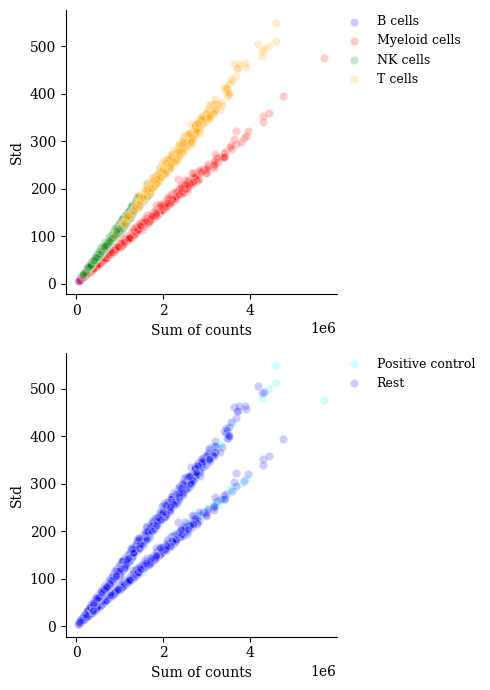

In [247]:
xs = sum_count
ys = np.std(np.abs(bulk_adata.X), axis=1)
   
plot_scatter(bulk_adata.obs, ['cell_type', 'sm_name'], xs, ys, x_label='Sum of counts', y_label='Std', log=False, log_y=False)

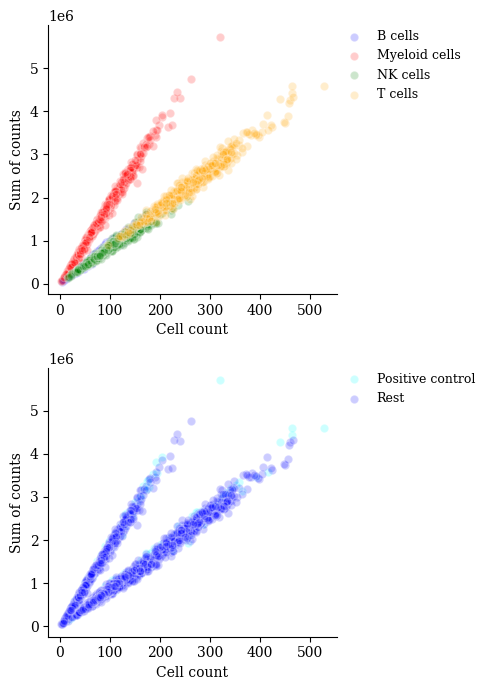

In [248]:
xs = cell_count.values
ys = sum_count
fig, axes = plot_scatter(bulk_adata.obs, obs_index, xs, ys, x_label='Cell count', y_label='Sum of counts', log=False, log_y=False)

# fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Number of psuedobulked samples 

In [249]:
sample_n = bulk_adata.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.fillna(0, inplace=True) # fill nans and sort for train cell type

sample_n['total'] = sample_n.sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells,total
sm_name,,,,,
Flutamide,3,3,3,3,12
Colchicine,3,3,3,3,12
Dimethyl Sulfoxide,48,48,48,48,192
Belinostat,48,48,48,48,192
Dabrafenib,48,48,48,48,192


133


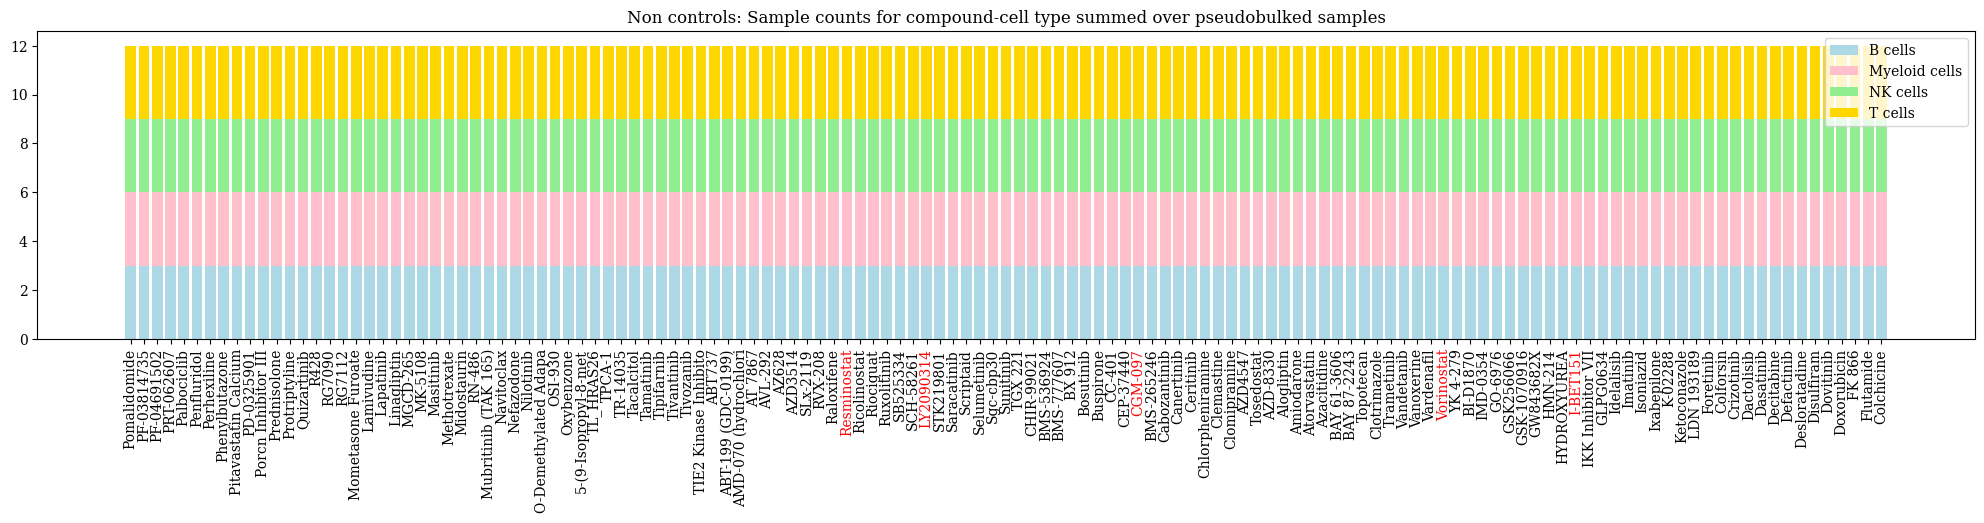

In [250]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index
cell_types = bulk_adata.obs['cell_type'].unique()

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

fig, ax = plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))
plt.legend()

## Ratio of cell counts in pseudobulked samples

In [251]:
cell_count = bulk_adata.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].sum())
sum_counts_celltypes = cell_count.reset_index().drop(columns='sm_name').groupby('cell_type').sum().reset_index()
sum_counts_celltypes_dict = sum_counts_celltypes.set_index('cell_type').to_dict()[0]

sum_counts_celltypes_dict

{'B cells': 45434,
 'Myeloid cells': 47137,
 'NK cells': 57174,
 'T cells': 141719}

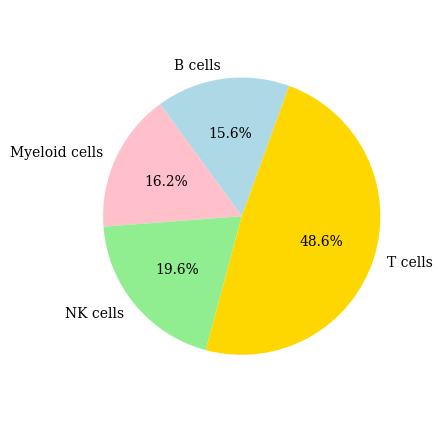

In [252]:
fig, ax = plt.subplots(1,1 , figsize=(4.5, 4.5))  # Adjust the figure size as needed
ax.pie(sum_counts_celltypes_dict.values(), labels=sum_counts_celltypes_dict.keys(), autopct='%1.1f%%', startangle=70, colors=colors_cell_type)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

## Cell count distribution: compound based  

### Controls

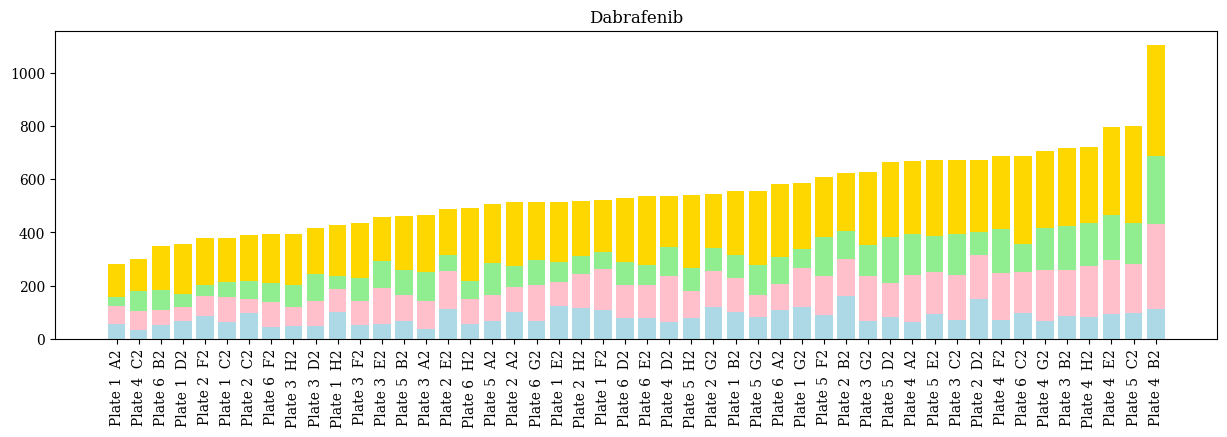

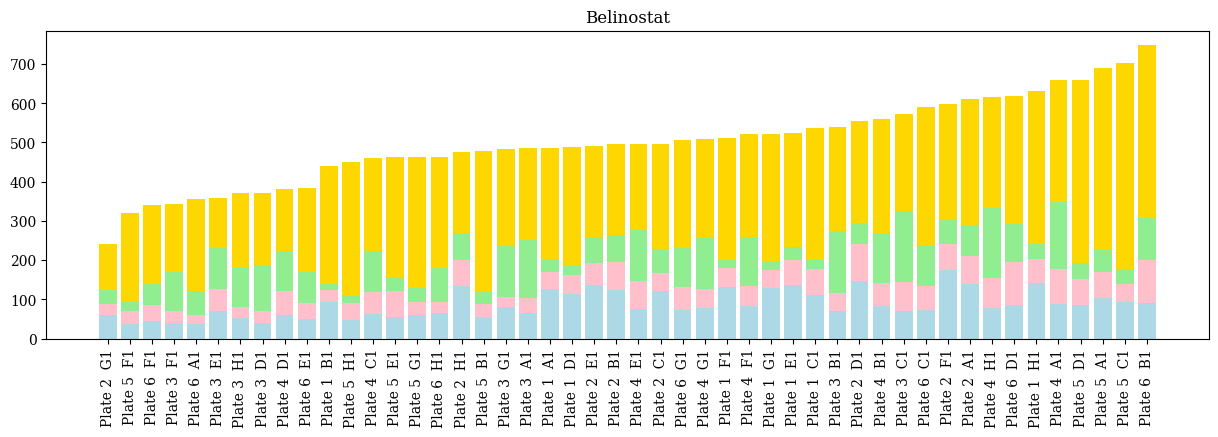

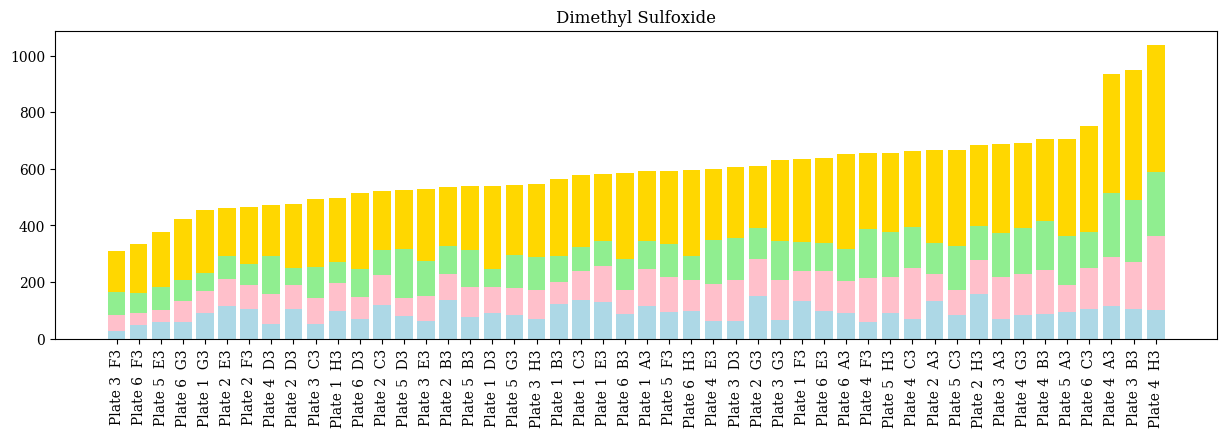

In [253]:
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}

for i_control, control_compound in enumerate(controls3):
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==control_compound]
    df_subset.plate_name = df_subset.plate_name.map(plate_name_map)
    df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
    df_subset = df_subset[['plate_name_well', 'cell_type', 'cell_count']]

    # outlier 
    outliers = isolation_forest(df_subset, group=['plate_name_well'])
    # plot 
    cell_count_m = df_subset.pivot(index='plate_name_well', columns='cell_type', values='cell_count')
    

    cell_count_m['sum'] = cell_count_m.sum(axis=1)
    cell_count_m = cell_count_m.fillna(0)
    cell_count_m = cell_count_m.sort_values('sum')
    cell_count_m = cell_count_m.drop(columns='sum')
    
    # plot
    colors = None
    # for label in cell_count_m.index.values:
    #     if label in outliers:
    #         colors.append('red')
    #     else:
    #         colors.append('black')
    plot_stacked_bar_chart(cell_count_m, title=control_compound, xticklabels=cell_count_m.index.values, colors=colors, figsize=(15, 4))

### Non controls

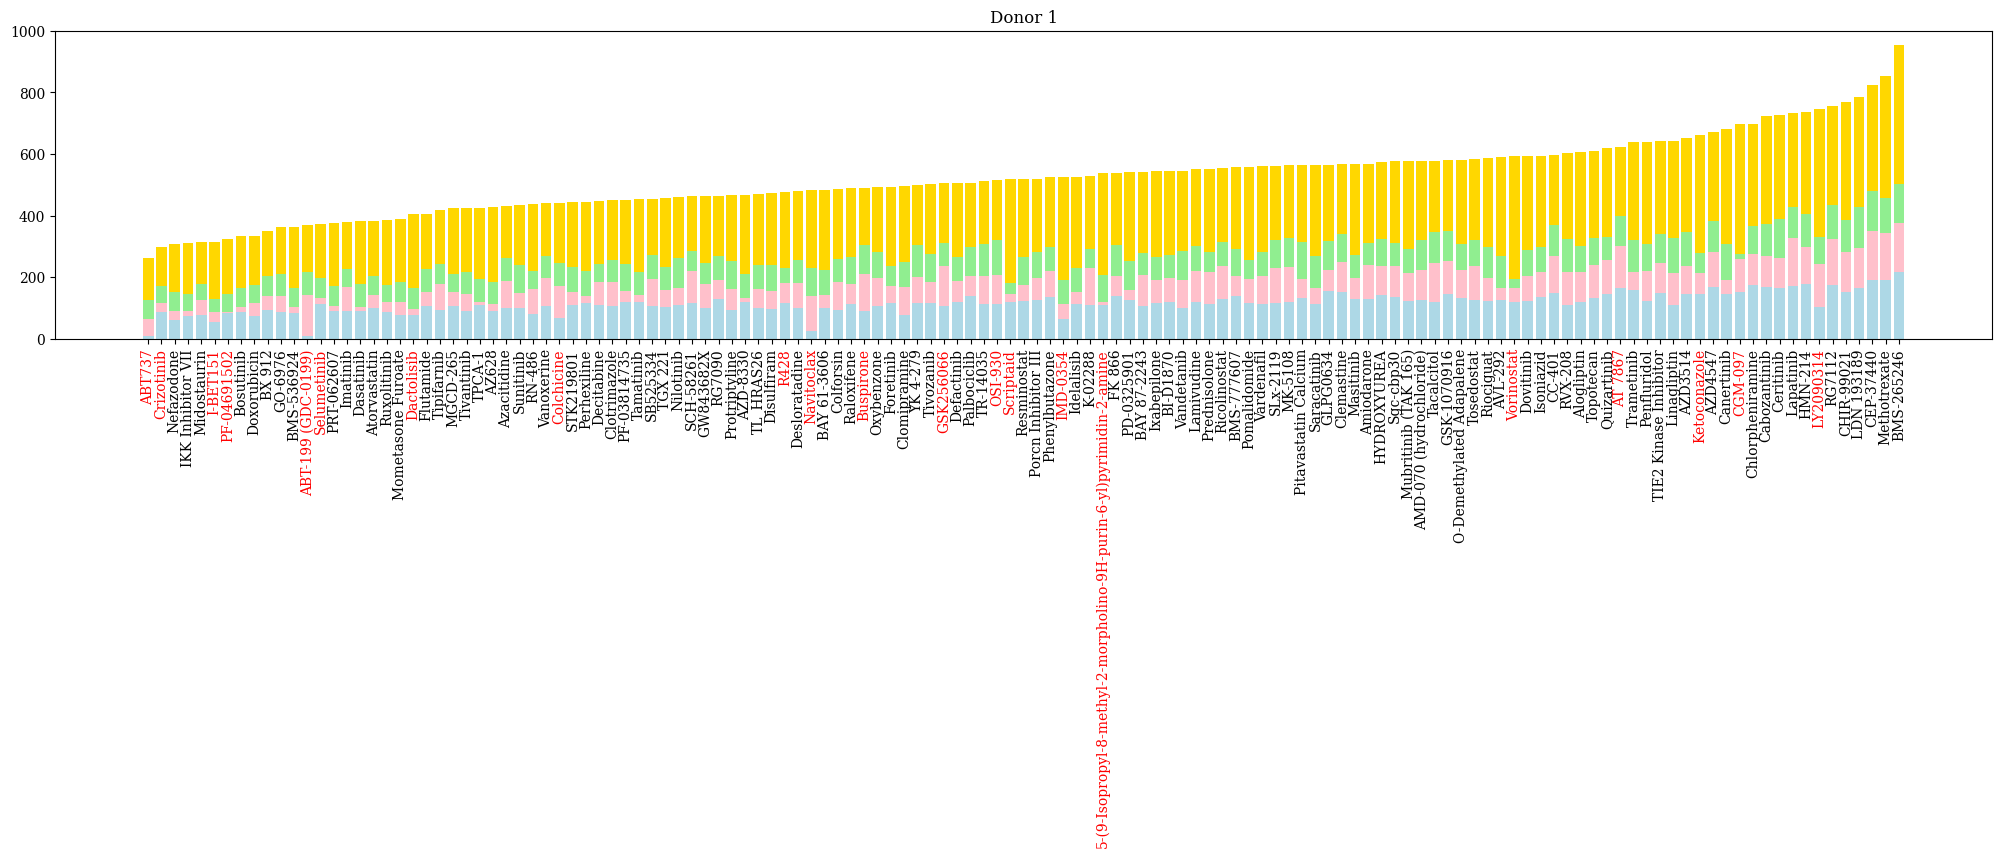

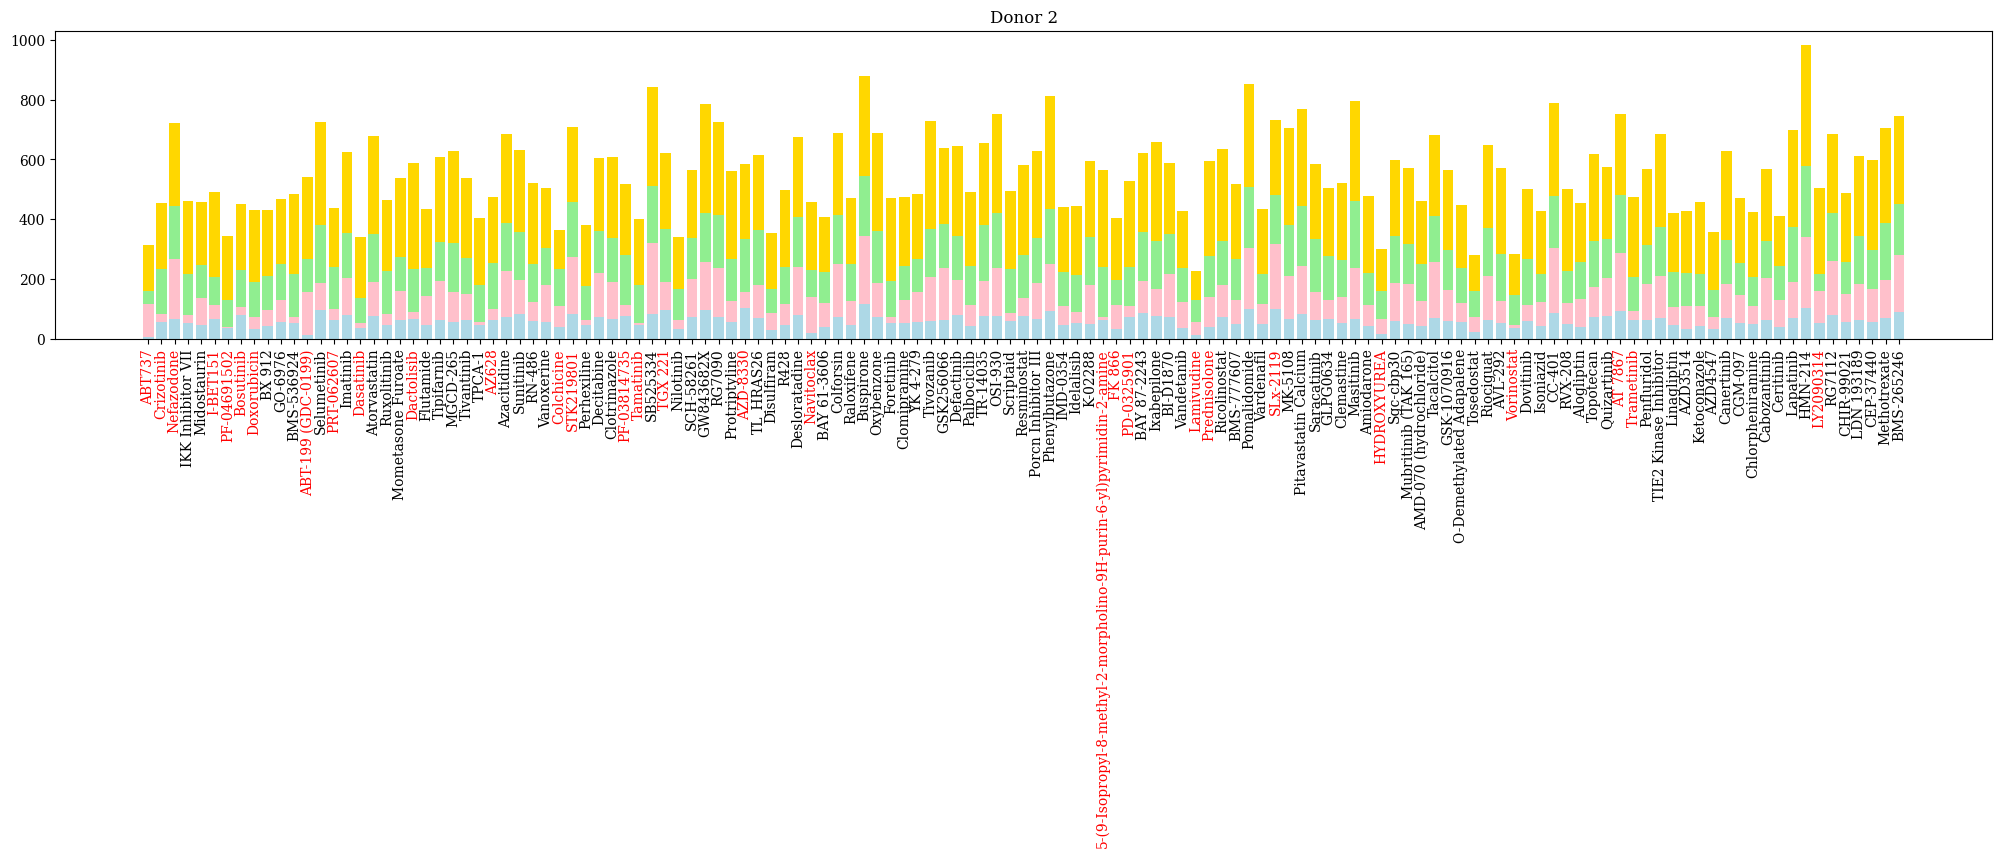

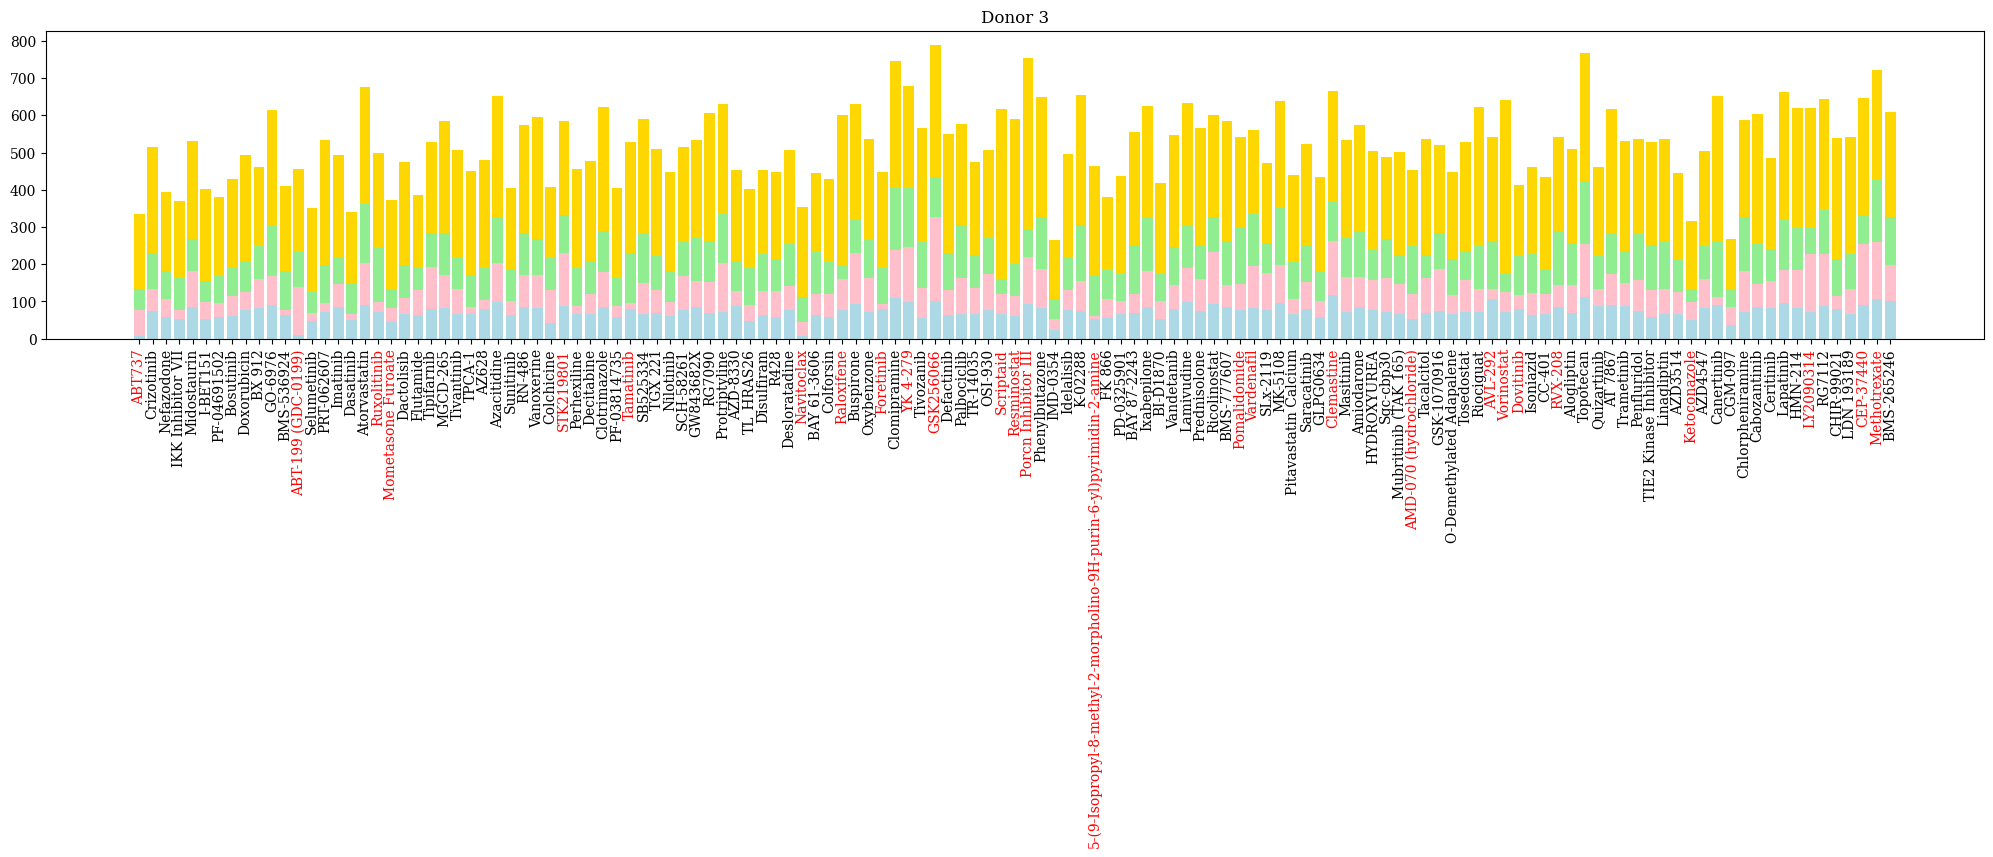

In [254]:
bulk_adata_non_controls = bulk_adata[~bulk_adata.obs.sm_name.isin(controls3), :]
donor_ids = bulk_adata.obs.donor_id.unique()
outliers_list = []
for i_donor, donor_id in enumerate(donor_ids):
    # subset and format data
    df_subset = bulk_adata_non_controls.obs[bulk_adata_non_controls.obs.donor_id==donor_id][['sm_name', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)

    # outlier 
    outliers = isolation_forest(df_subset, group=['sm_name'])    
    outliers_list.append(outliers)
    
    # save the order
    if i_donor==0:
        
        cell_count_m['sum'] = cell_count_m.sum(axis=1)
        cell_count_m = cell_count_m.sort_values('sum')
        cell_count_m = cell_count_m.drop(columns='sum')
        saved_order = cell_count_m.index
        
    else:
        cell_count_m = cell_count_m.reindex(saved_order)

    colors = []
    for label in cell_count_m.index.values:
        if label in outliers:
            colors.append('red')
        else:
            colors.append('black')
    plot_stacked_bar_chart(cell_count_m, title=donor_id, xticklabels=cell_count_m.index.values, colors=colors, figsize=(25, 4))

In [255]:
all_outliers = np.unique(np.concatenate(outliers_list))
common_outliers = np.intersect1d(outliers_list[0], outliers_list[1])
common_outliers = np.intersect1d(common_outliers, outliers_list[2])
outliers_1 = ['Alvocidib', 'CGP 60474', 'UNII-BXU45ZH6LI'] # toxic
outliers_2 = ['Oprozomib (ONX 0912)','MLN 2238', 'CEP-18770 (Delanzomib)',  'IN1451', 'BMS-387032'] # big shift, less than 2 cells types left
outliers_3 = ['Ganetespib (STA-9090)', 'Proscillaridin A;Proscillaridin-A', 'AT13387'] # MOA not clear
included_outliers = outliers_1+ outliers_2 + outliers_3

5


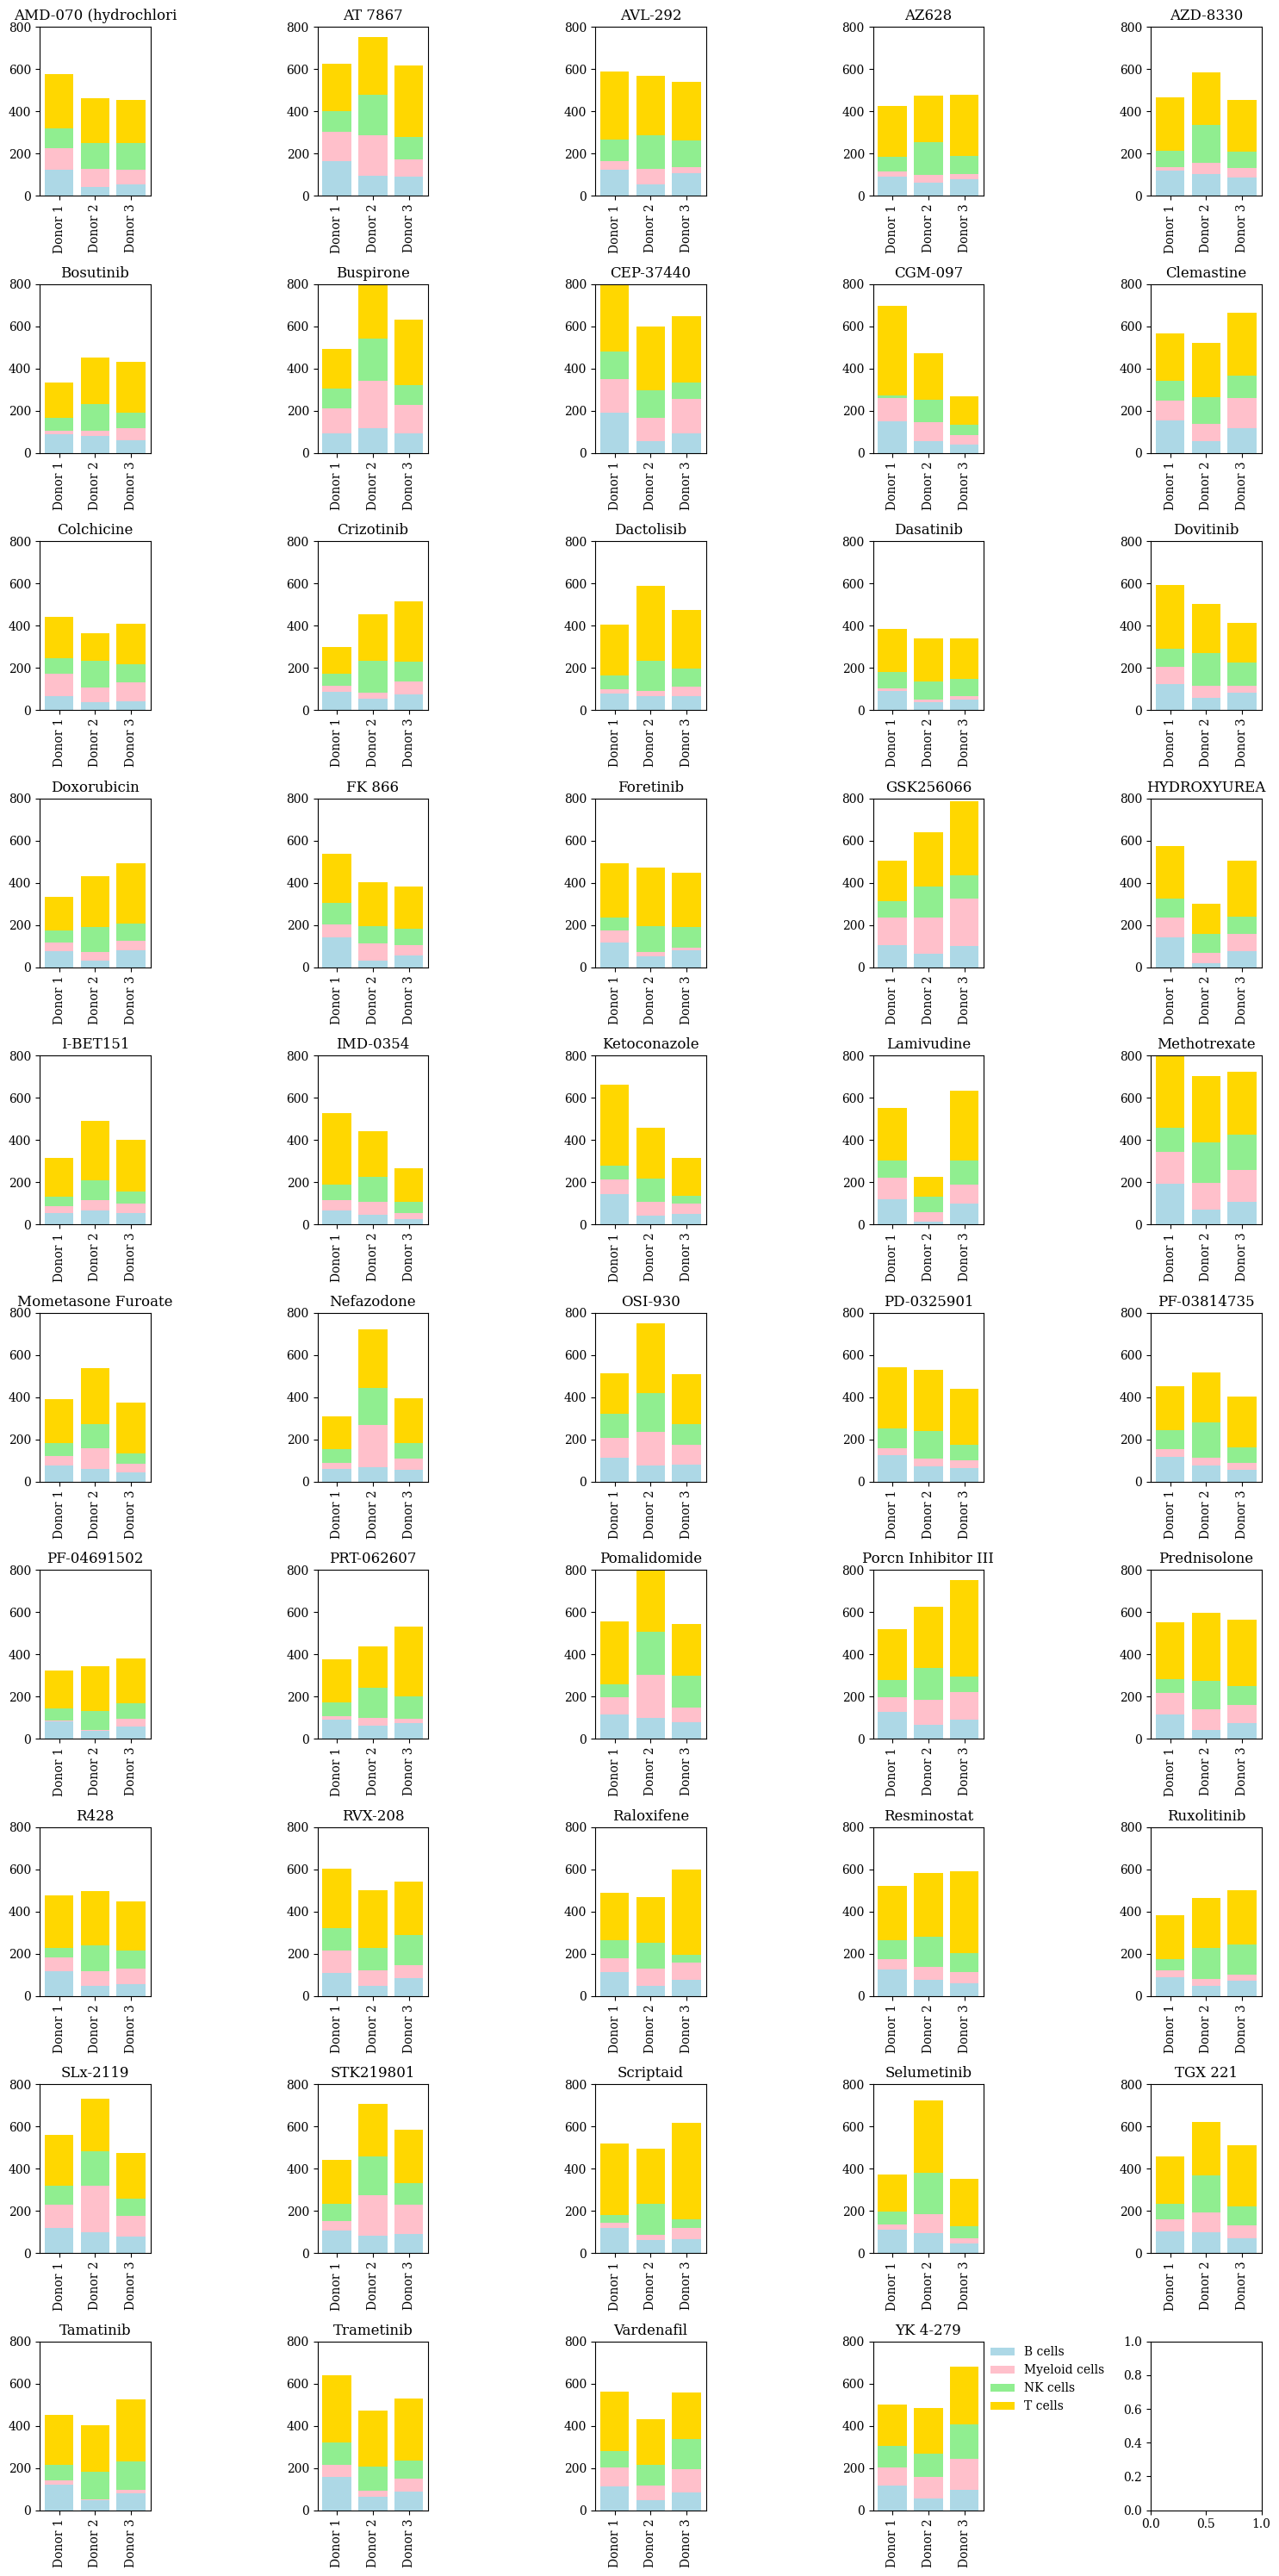

In [256]:
group_to_plot = np.setdiff1d(all_outliers, common_outliers)
# group_to_plot = diff_outliers_2
n_cols = min([5, len(group_to_plot)])
n_rows = int(np.ceil(len(group_to_plot)/n_cols))
print(n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

ax_list = []
for i_compound, compound in enumerate(group_to_plot):
    i = i_compound // n_cols
    j = i_compound % n_cols
    if n_rows==1:
        ax = axes[j]
    else:
        ax = axes[i][j]
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)
    
    ax.set_ylim([0, 800])
    plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
    ax_list.append(ax)
ax_list[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()

## Missing counts

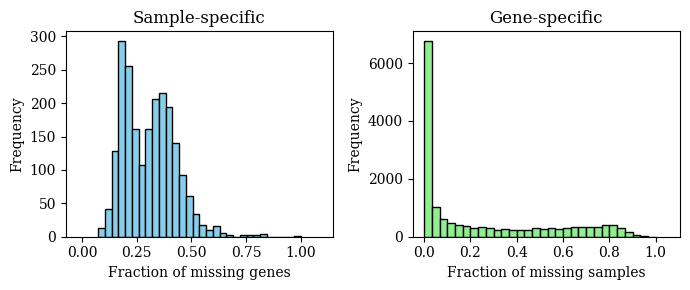

In [257]:
def plot_bipartite(data):
    # Calculate sparsity for observations (samples)
    obs_sparsity = (data == 0).sum(axis=1)
    obs_sparsity = obs_sparsity/obs_sparsity.max()
    # Calculate sparsity for variables (genes)
    var_sparsity = (data == 0).sum(axis=0)
    var_sparsity = var_sparsity/var_sparsity.max()

    # Plot histograms for observations and variables
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot histogram for observation-specific sparsity
    ax = axs[0]
    ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
    ax.set_title('Sample-specific')
    ax.set_xlabel('Fraction of missing genes')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.1 * (x_max - x_min)
    ax.set_xlim(x_min-x_margin, x_max + x_margin)

    # Plot histogram for variable-specific sparsity
    ax = axs[1]
    ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
    ax.set_title('Gene-specific')
    ax.set_xlabel('Fraction of missing samples')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.05 * (x_max - x_min)
    ax.set_xlim(x_min, x_max + x_margin)

    return fig, axes

fig, axes = plot_bipartite(data=bulk_adata.X)
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()


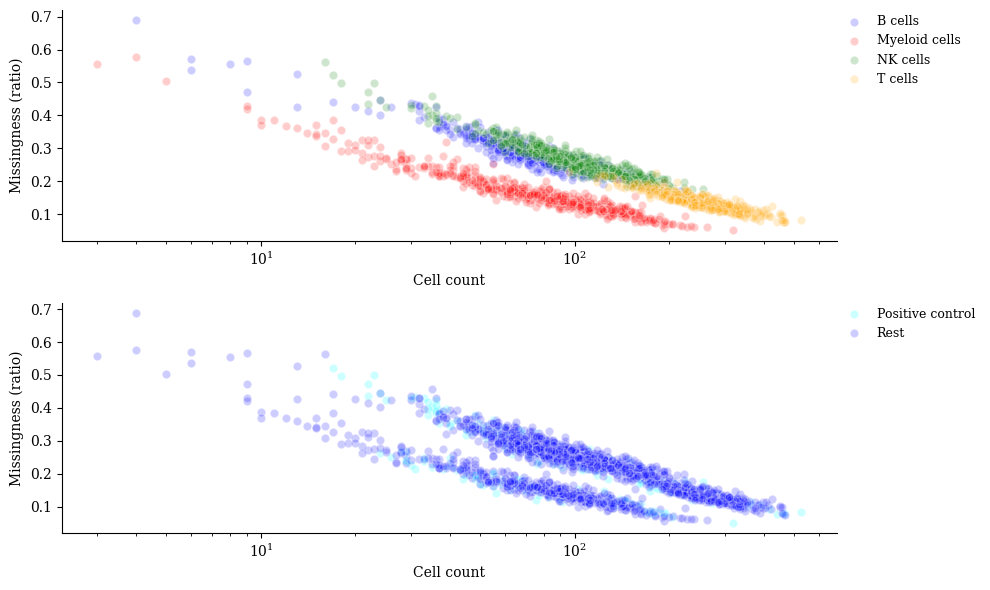

In [299]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
bulk_adata_df = pd.DataFrame(bulk_adata.X)

xs = bulk_adata.obs.cell_count
ys = missingness



fig, axes = plot_scatter(bulk_adata.obs, ['cell_type','sm_name'], xs, ys, x_label='Cell count', y_label='Missingness (ratio)', log=True, log_y=False, figsize=(10, 6))


In [297]:
bulk_adata.obs[missingness>.6].sm_name.unique()
bulk_adata.obs[bulk_adata.obs.cell_count<10].cell_type.unique()


['Myeloid cells', 'B cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

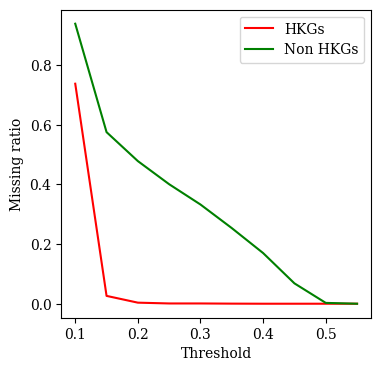

In [259]:
# aqad
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
missingness = (bulk_adata.X==0).sum(axis=0)/bulk_adata.shape[0]
sum_count = bulk_adata.X.sum(axis=0)

ys = missingness

all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]

ratio_hkgs_list = []
ratio_nonhkgs_list = []
thresholds = np.arange(0,1,.1)
for tt in thresholds:
    mask = missingness>tt
    ratio_hkgs_list.append((mask_hkgs*mask).sum()/mask_hkgs.sum())
    ratio_nonhkgs_list.append(((~mask_hkgs)*mask).sum()/(~mask_hkgs).sum())
# plot
fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=False)
ax.plot(thresholds, ratio_hkgs_list, label='HKGs', color='red')
ax.plot(thresholds, ratio_nonhkgs_list, label='Non HKGs', color='green')
ax.set_xlabel('Threshold')
ax.set_ylabel('Missing ratio')
ax.set_xticklabels(np.round(thresholds,1))
ax.legend()

## Low cell count

In [337]:
mask_low_cellcount = (bulk_adata.obs.cell_count<10)
print('samples:',mask_low_cellcount.sum(), 
      'compounds: ', bulk_adata[mask_low_cellcount].obs.sm_name.unique().shape,
      'cell type: ', bulk_adata[mask_low_cellcount].obs.cell_type.unique())

donor_size = bulk_adata[mask_low_cellcount].obs.reset_index().groupby(['sm_name','cell_type']).size()
donor_size

samples: 11 compounds:  (7,) cell type:  ['Myeloid cells', 'B cells']
Categories (2, object): ['B cells', 'Myeloid cells']


sm_name                                                               cell_type    
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine  B cells          0
                                                                      Myeloid cells    1
ABT737                                                                B cells          3
                                                                      Myeloid cells    0
ABT-199 (GDC-0199)                                                    B cells          2
                                                                      Myeloid cells    0
Navitoclax                                                            B cells          1
                                                                      Myeloid cells    0
PF-04691502                                                           B cells          0
                                                                      Myeloid cells    2
Tamatinib                 

In [346]:
# remove those with more than 1 donor 
mask_extra_to_go = bulk_adata.obs.set_index(['sm_name','cell_type']).index.isin(donor_size[donor_size>1].index)
mask_low_cellcount = mask_low_cellcount + mask_extra_to_go
print('all samples to go due to low cell count: ', mask_low_cellcount.sum())

all samples to go due to low cell count:  13


## Low gene coverage 

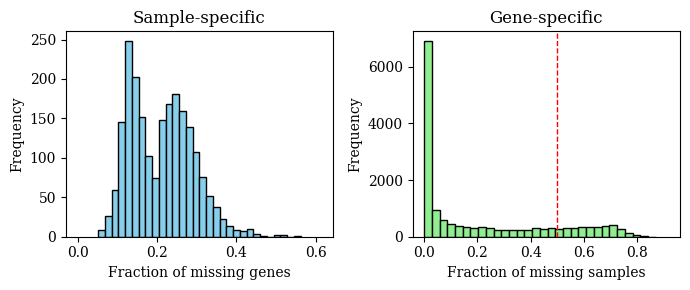

In [379]:
threshold = 0.5
def plot_bipartite(data):
    # Calculate sparsity for observations (samples)
    obs_sparsity = (data == 0).sum(axis=1)
    obs_sparsity = obs_sparsity/data.shape[1]
    # Calculate sparsity for variables (genes)
    var_sparsity = (data == 0).sum(axis=0)
    var_sparsity = var_sparsity/data.shape[0]

    # Plot histograms for observations and variables
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot histogram for observation-specific sparsity
    ax = axs[0]
    ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
    ax.set_title('Sample-specific')
    ax.set_xlabel('Fraction of missing genes')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.1 * (x_max - x_min)
    ax.set_xlim(x_min-x_margin, x_max + x_margin)

    # Plot histogram for variable-specific sparsity
    ax = axs[1]
    ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
    ax.set_title('Gene-specific')
    ax.set_xlabel('Fraction of missing samples')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.05 * (x_max - x_min)
    ax.set_xlim(x_min, x_max + x_margin)

    return fig, axes

fig, axes = plot_bipartite(data=bulk_adata.X)

# fig.get_axes()[0].axvline(x=threshold, color='red', linestyle='--', linewidth=1)
fig.get_axes()[1].axvline(x=threshold, color='red', linestyle='--', linewidth=1)
plt.tight_layout()



fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()

In [ ]:
data = bulk_adata.X
var_sparsity = (data == 0).sum(axis=0)
var_sparsity = var_sparsity/data.shape[0]
mask_to_go_genes = var_sparsity>0.5
to_go_genes = bulk_adata.var_names[mask_to_go_genes]
np.intersect1d(to_go_genes, hvgs).shape


# Filtering

In [260]:
if False: # filter 1
    bulk_adata = bulk_adata[~bulk_adata.obs.sm_name.isin(included_outliers),:] 
    bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_complete_tcells_filter1.h5ad')

In [348]:
if True: # filter 2
    bulk_adata = bulk_adata[~mask_low_cellcount,:] 
    # bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_complete_tcells_filter1.h5ad')

In [386]:
if True: # filter 3
    # bulk_adata = bulk_adata[:,~mask_to_go_genes] 
    bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_complete_tcells_filter3.h5ad')

In [261]:
//

SyntaxError: invalid syntax (411536581.py, line 1)

## Samples to go due to insufficient cell types left
If we remove problamatic samples, lets check the cell types left for each drug.

sm_name                                                               cell_type    
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine  B cells          0
                                                                      Myeloid cells    1
ABT737                                                                B cells          3
                                                                      Myeloid cells    0
ABT-199 (GDC-0199)                                                    B cells          2
                                                                      Myeloid cells    0
Navitoclax                                                            B cells          1
                                                                      Myeloid cells    0
PF-04691502                                                           B cells          0
                                                                      Myeloid cells    2
Tamatinib                 

In [303]:
def check_coverage(bulk_adata):
    df = bulk_adata.obs.groupby('sm_name').apply(lambda df: df['cell_type'].unique())
    # should be either B cells or Myeloid cells remaining 
    mask_1 = np.asarray([('B cells' in item) or ('Myeloid cells' in item) for item in df.values])
    print('to go compounds: ', (~mask_1).sum())
    # should have at least 4 cell types left
    mask_2 = np.asarray([len(item)>=3 for item in df.values])
    print('to go compounds: ', (~mask_2).sum())
check_coverage(bulk_adata[(bulk_adata.obs.cell_count>=10)])

to go compounds:  0
to go compounds:  0


In [ ]:
# compounds to keep
to_keep_compounds = df.index.values[mask_1*mask_2]
to_keep_compounds.shape

(138,)

In [ ]:
# apply actual filtering
bulk_adata = bulk_adata[bulk_adata.obs.sm_name.isin(to_keep_compounds),:]
bulk_adata

View of AnnData object with n_obs × n_vars = 2645 × 11169
    obs: 'plate_well_cell_type', 'cell_type', 'donor_id', 'sm_name', 'dose_uM', 'hashtag_id', 'timepoint_hr', 'raw_cell_id', 'row', 'container_format', 'well', 'plate_name', 'col', 'positive_ctr', 'split', 'cell_id', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [ ]:
(bulk_adata.X.flatten()==0).sum()/bulk_adata.X.flatten().size

0.09067566673284362

In [ ]:
bulk_adata.obs.reset_index(drop=True, inplace=True)
# bulk_adata.var.reset_index(drop=True, inplace=True)

In [ ]:
print('compounds left:', bulk_adata.obs.sm_name.unique().shape)

compounds left: (138,)


collection

compounds left: (132,)

In [ ]:
# save filtered adata
bulk_adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

In [ ]:
aa

(array([1.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 1.000000e+00, 3.000000e+00,
        2.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        2.000000e+00, 2.000000e+00, 4.000000e+00, 8.000000e+00,
        8.000000e+00, 1.100000e+01, 1.200000e+01, 6.000000e+00,
        8.000000e+00, 1.300000e+01, 1.500000e+01, 1.300000e+01,
        1.200000e+01, 2.000000e+01, 2.000000e+01, 3.500000e+01,
        2.900000e+01, 3.600000e+01, 4.500000e+01, 4.200000e+01,
        6.100000e+01, 8.300000e+01, 9.100000e+01, 1.220000e+02,
        1.380000e+02, 1.760000e+02, 2.290000e+02, 2.620000e+02,
        3.130000e+02, 4.070000e+02, 5.590000e+02, 8.270000e+02,
        1.203000e+03, 2.004000e+03, 4.574000e+03, 2.299600e+04,
        2.764725e+06, 5.726883e+06, 5.264300e+04, 1.045500e+04,
        4.198000e+03, 2.224000e+03, 1.276000e+03, 8.150000e+02,
        5.980000e+02, 3.800000e+02, 3.030000e+02, 2.340000e+02,
        2.140000e+02, 1.320000e+02, 1.15

# EDA after filtering

In [388]:
# bulk_adata_f = ad.read(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata_f = bulk_adata

## Distribution of pseudobulkd samples 

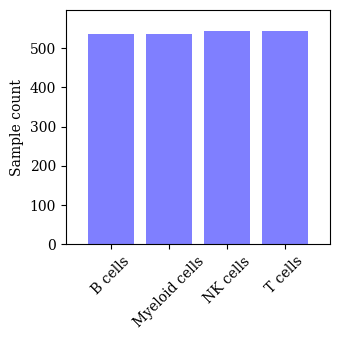

In [389]:
samples_counts = bulk_adata_f.obs.groupby('cell_type').size().to_dict()

fig, ax = plt.subplots(1,1 , figsize=(3.5, 3.5))  # Adjust the figure size as needed
ax.bar(samples_counts.keys(), samples_counts.values(), color='blue', alpha=0.5)
ax.set_ylabel('Sample count')
ax.margins(0.1)
plt.tick_params('x', rotation=45)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

In [264]:
samples_counts

{'B cells': 543, 'Myeloid cells': 543, 'NK cells': 543, 'T cells': 543}

## Distribution of pseudobulkd samples per compound

In [390]:
sample_n = bulk_adata_f.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.fillna(0, inplace=True) # fill nans and sort for train cell type

sample_n['total'] = sample_n.sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells,total
sm_name,,,,,
Dasatinib,3,3,3,3,12
Dactolisib,3,3,3,3,12
Belinostat,48,48,48,48,192
Dimethyl Sulfoxide,48,48,48,48,192
Dabrafenib,48,48,48,48,192


133


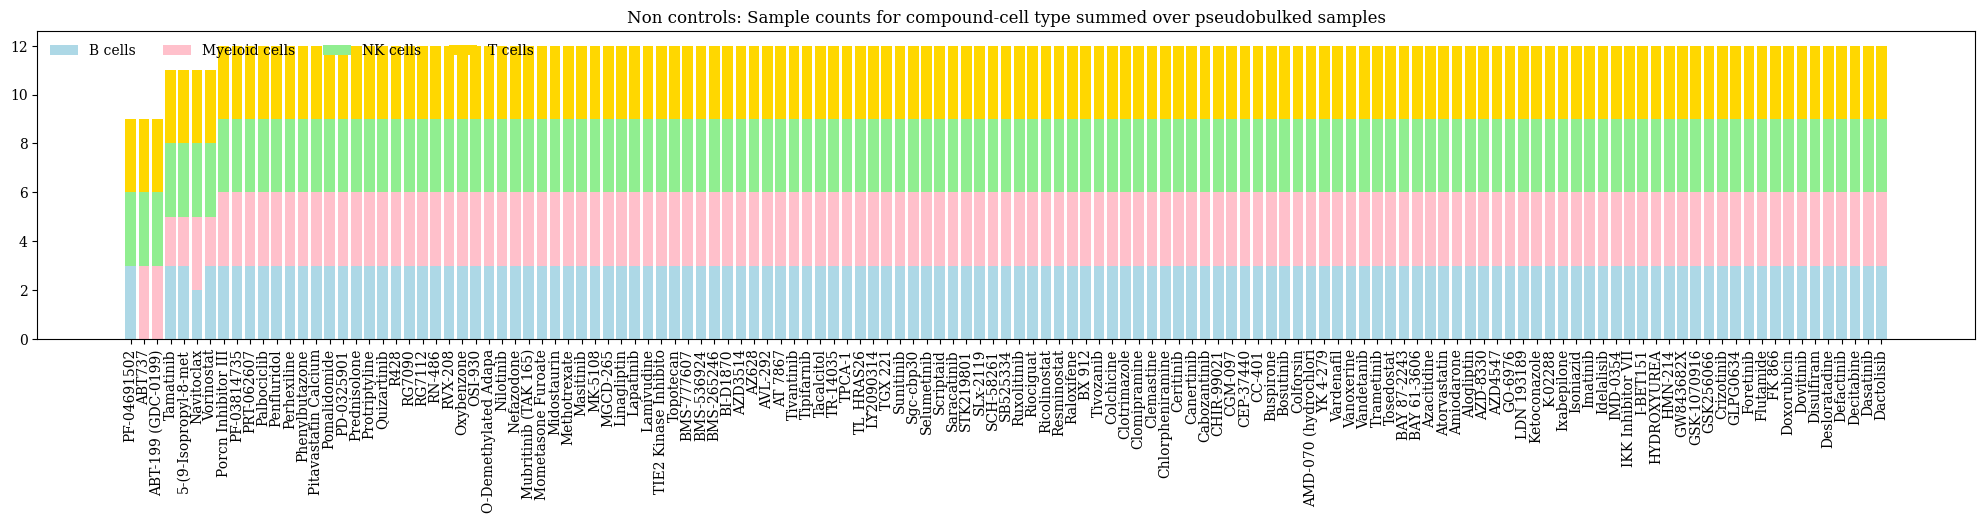

In [397]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = None
# for i, sm_name in enumerate(xticklabels):
#     if sm_name in outliers_me:
#         colors.append('red')
#     else:
#         colors.append('black')

fig, ax = plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))
ax.legend(ncol=4, frameon=False, loc='upper left')


## Donor-specific cell type ratio 

In [392]:
donor_cellcounts = bulk_adata_f.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').apply(lambda df2: df2['cell_count'].sum()))
donor_samplesize = bulk_adata_f.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').size())
donor_samplesize_n = donor_samplesize/donor_cellcounts
adj_coeff = 1/(donor_samplesize/donor_cellcounts).sum(axis=1)
donor_samplesize_n = donor_samplesize_n.mul(adj_coeff, axis=0)
donor_samplesize_n

cell_type,B cells,Myeloid cells,NK cells,T cells
donor_id,,,,
Donor 1,0.225232,0.328863,0.339492,0.106413
Donor 2,0.436762,0.260621,0.195976,0.106642
Donor 3,0.336542,0.320481,0.253309,0.089668


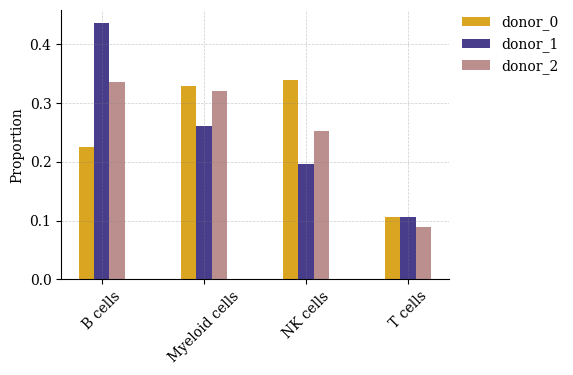

In [393]:
plt.figure(figsize=(5, 3.5))
ax = plt.subplot(1, 1, 1)
width = 0.15
BOUNDS = {'NK cells': (0.03, 0.18), 'T cells CD4+': (0.33, 0.51), 'T cells CD8+': (0.16, 0.26), 'T regulatory cells': (0.01, 0.05), 'Myeloid cells': (0.11, 0.22), 'B cells': (0.03, 0.09)}

for i in range(3):
    color = ['goldenrod', 'darkslateblue', 'rosybrown'][i]
    proportions = donor_samplesize_n.iloc[i,:]
    plt.bar(np.arange(len(cell_types))-0.15+0.15*i, proportions, label=f'donor_{i}', width=width, color=color)
plt.xticks(np.arange(len(cell_types)), cell_types, rotation=45)
plt.ylabel('Proportion')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
plt.legend( bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

## Highly variable genes

In [394]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [395]:
n_hvgs = 3000

In [396]:
%%R -i adata_tag -i work_dir # run this from terminal 
library(scry)
library(zellkonverter)
library(SingleCellExperiment)

work_dir = './output'
adata_tag = 'complete_tcells_filter1'
adata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_", adata_tag, ".h5ad")) # raw counts
sce = scry::devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))

Error in checkForRemoteErrors(lapply(cl, recvResult)) : 
  one node produced an error: FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_complete_tcells_filter1.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Run `reticulate::py_last_error()` for details.


RInterpreterError: Failed to parse and evaluate line '# run this from terminallibrary(scry)\nlibrary(zellkonverter)\nlibrary(SingleCellExperiment)\n\nwork_dir = \'./output\'\nadata_tag = \'complete_tcells_filter1\'\nadata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_", adata_tag, ".h5ad")) # raw counts\nsce = scry::devianceFeatureSelection(adata, assay="X")\nwriteH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))\n'.
R error message: "Error in checkForRemoteErrors(lapply(cl, recvResult)) : \n  one node produced an error: FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_complete_tcells_filter1.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)\nRun `reticulate::py_last_error()` for details."

In [ ]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

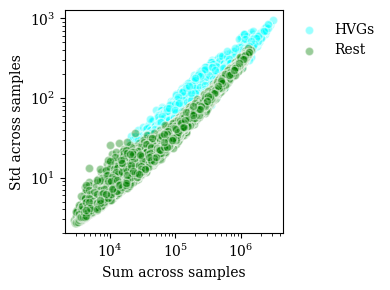

In [ ]:
genes = hvgs_sce
adata_f = bulk_adata_f
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = adata_f.var
var['sum'] = adata_f.X.sum(axis=0)
var['std'] = adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


ax.set_ylabel('Std across samples')
ax.set_xlabel('Sum across samples')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
all_genes = bulk_adata_f.var.index.values
mask_hkgs = bulk_adata_f.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]
non_hkgs.shape

(12539,)

In [ ]:
hvgs = hvgs_sce
genesets_dict = {'HKGs':housekeeping_genes, 'Rest': non_hkgs}
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {} # top percentile score versus randomly selected genes with the same dimension
n_random = 1000
for name, geneset in genesets_dict.items():
    shared_genes = np.intersect1d(geneset, all_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(all_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
print(f'{hvgs_intersection_ratio_dict=} \n {top_p_dict=}')

hvgs_intersection_ratio_dict={'HKGs': 0.130498966637142, 'Rest': 0.2040035090517585} 
 top_p_dict={'HKGs': 1.0, 'Rest': 0.0}


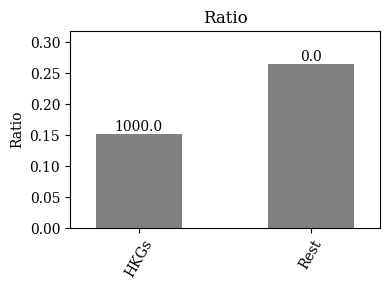

In [ ]:
hvgs = hvgs_sce

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color='grey')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(ax,  hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

## Missingness versus HVGS

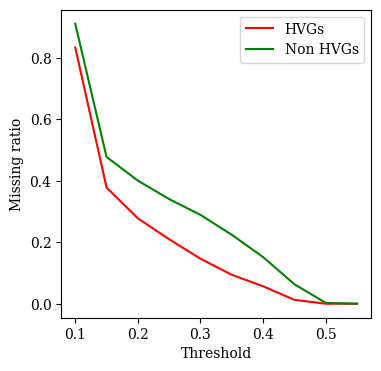

In [ ]:
# aqad
missingness = (bulk_adata.X==0).sum(axis=0)/bulk_adata.shape[0]
sum_count = bulk_adata.X.sum(axis=0)

ys = missingness

all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(hvgs)
non_hkgs = all_genes[~mask_hkgs]

ratio_hkgs_list = []
ratio_nonhkgs_list = []
thresholds = np.arange(0,1,.1)
for tt in thresholds:
    mask = missingness>tt
    ratio_hkgs_list.append((mask_hkgs*mask).sum()/mask_hkgs.sum())
    ratio_nonhkgs_list.append(((~mask_hkgs)*mask).sum()/(~mask_hkgs).sum())
# plot
fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=False)
ax.plot(thresholds, ratio_hkgs_list, label='HVGs', color='red')
ax.plot(thresholds, ratio_nonhkgs_list, label='Non HVGs', color='green')
ax.set_xlabel('Threshold')
ax.set_ylabel('Missing ratio')
ax.set_xticklabels(np.round(thresholds,1))
ax.legend()

# Normalize

In [ ]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_bulk_data_def.h5ad')
bulk_adata_bulk_data_def.layers['counts'] = bulk_adata_f.X
bulk_adata_de

AnnData object with n_obs × n_vars = 2117 × 12772
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    layers: 'counts'

In [ ]:
assert (bulk_adata_de.X.flatten()==0).sum()/bulk_adata_de.X.flatten().size>0
# assert type(bulk_adata_de.X.flatten()[0])==int

## Scanpy shifted algorithm

In [ ]:
from sklearn.impute import KNNImputer
def knn_imputer(adata):
    imputer = KNNImputer(n_neighbors=10)
    data = adata.X
    mask = data==0
    data[mask] = np.nan
    adata.X = imputer.fit_transform(data)

adata = bulk_adata_de.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata)
# print(adata.var.highly_variable.sum())
# if True:
    
#     knn_imputer(adata)
    # sce.pp.magic(adata, knn=20, n_pca=20, solver='exact')
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)

    # sc.pp.highly_variable_genes(adata)
    # print('HVGs', adata.var.highly_variable.sum())
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_de_n_shifted_algorithm.h5ad')

In [ ]:
(adata.X.flatten()==0).sum()/adata.X.flatten().size

0.1016425426368883

In [ ]:
if False:
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    print('HVGs', adata.var.highly_variable.sum())

## Scanpy pearson residuals
The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. 

In [ ]:

adata = bulk_adata_f.copy()
sc.experimental.pp.normalize_pearson_residuals(adata)
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_pearson.h5ad')


# EDA on normalized data

In [ ]:
norm_tag = 'n_shifted_algorithm' # n_shifted_algorithm, n_pearson
adata_n = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f_{norm_tag}.h5ad')
obs_index = ['cell_type','sm_name']
adata_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']

adata = adata_n.copy()

adata_df = pd.DataFrame(adata.X, index= pd.MultiIndex.from_frame(adata.obs[adata_index]))
sum_count = adata_df.sum(axis=1)
cell_count = adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(adata_df)
non_missing_count = (adata_df!=0).sum(axis=1)
top_quantile = (adata_df>adata_df.quantile(.95, axis=0)).sum(axis=1)/adata_df.shape[1]

if False:
    std = np.std(np.abs(adata_df), axis=1)
else:
    std = []
    for index, row in adata_df.iterrows():
        std.append(np.std(row[row!=0]))
    std = pd.DataFrame(std, index=adata_df.index)
print('sparsity', (adata.X.flatten()==0).sum()/adata.X.flatten().size)

sparsity 0.1016425426368883


## Normality

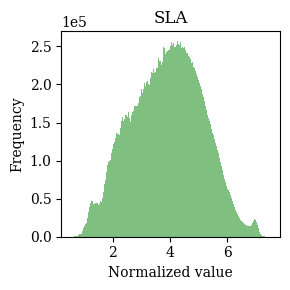

In [ ]:
import matplotlib.pyplot as plt

# Define colors
color = 'green'

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)

# Plot histogram
data = adata.X.flatten()
data = data[data!=0]
ax.hist(data, bins=200, color=color, alpha=.5)

# Set axis labels and title
ax.set_xlabel('Normalized value')
ax.set_ylabel('Frequency')
if norm_tag == 'n_pearson':
    ax.set_xlim([-11,11])
    title = 'APR'
elif norm_tag == 'n_shifted_algorithm':
    title = 'SLA'
ax.ticklabel_format(axis='y', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
# Add margin to the plot
# ax.margins(0.05)
ax.set_title(title)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/norm_values_hist_{norm_tag}.png', dpi=100)
# Show plot
# plt.show()



## Std

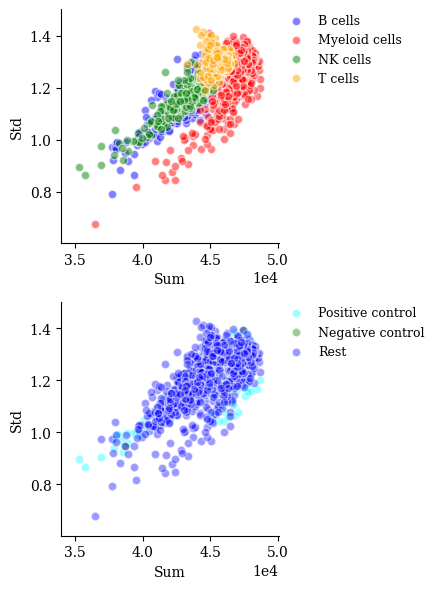

In [ ]:
xs = sum_count
ys = std

fig, axes = plot_scatter(adata_df, obs_index, xs, ys, x_label='Sum', y_label='Std', log=False, figsize=(4.5,6))
for ax in axes:
    ax.margins(0.1)
    ax.ticklabel_format(axis='x', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/std_sum_nomalized_{norm_tag}.png', dpi=100)

## Top quantile 

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>,
        <Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>],
       dtype=object))

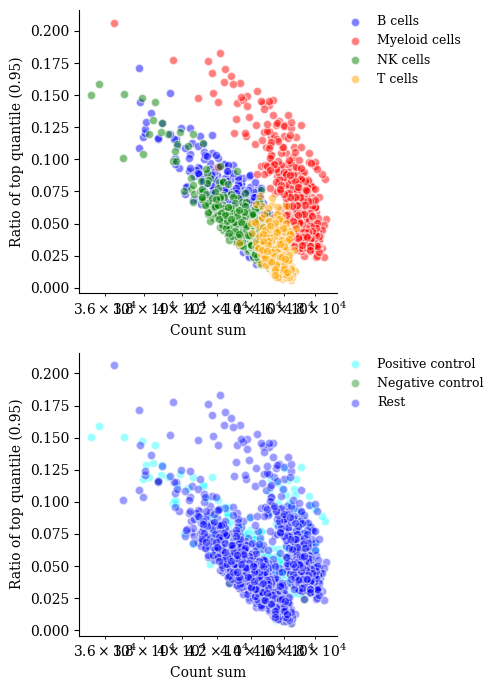

In [ ]:
ys = top_quantile
xs = sum_count

plot_scatter(adata_df, obs_index, xs, ys, x_label='Count sum', y_label='Ratio of top quantile (0.95)', log=True)

## Clusters

In [ ]:
adata_n_c = adata_n.copy()
with warnings.catch_warnings():
    sc.tl.pca(adata_n_c, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata_n_c, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata_n_c)

In [ ]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
# adata_n_c.obs['Donor'] = adata_n_c.obs.donor_id.map(map_names)
adata_n_c.obs['Cell type'] = adata_n_c.obs.cell_type

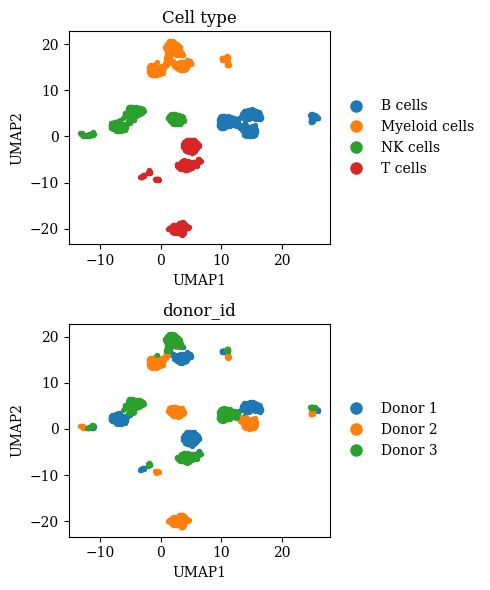

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=8)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'donor_id']): 
    cluster_plot(adata_n_c, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/normalized_cluster_{norm_tag}.png', dpi=150, transparent=True)
plt.show()

In [ ]:
aa 

NameError: name 'aa' is not defined

# DE analysis using EdgeR

In [ ]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')


# bulk_adata_f.var = bulk_adata_f.var.set_index('gene')
if True: #only hvgs
    hvgs = hvgs_sce
    bulk_data_de = bulk_adata_f[:, bulk_adata_f.var_names.isin(hvgs)]
else:
    bulk_data_de = bulk_adata_f
bulk_data_de

View of AnnData object with n_obs × n_vars = 2117 × 3000
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

### <a id='toc6_1_1_'></a>[Format adata](#toc0_)

In [ ]:
compound_name_col = 'sm_name'

# sm_name
unique_sm_name = bulk_data_de.obs.sm_name.unique()
sm_name_map = {sm_name:f'sm_name_{number}' for sm_name, number in zip(unique_sm_name, range(len(unique_sm_name)))}
sm_name_s_map = {value: key for key, value in sm_name_map.items()}
# cell type
unique_cell_type = bulk_data_de.obs.cell_type.unique()
cell_type_map = {cell_type:f'celltype_{number}' for cell_type, number in zip(unique_cell_type, range(len(unique_cell_type)))}
cell_type_s_map = {value: key for key, value in cell_type_map.items()}
bulk_data_de.obs['sm_name_s'] = bulk_data_de.obs['sm_name'].map(sm_name_map).astype(str)
bulk_data_de.obs['cell_type_s'] = bulk_data_de.obs['cell_type'].map(cell_type_map)
negative_control_s = sm_name_map[negative_control] 

bulk_data_de.var = bulk_data_de.var.reset_index()

bulk_data_de

AnnData object with n_obs × n_vars = 2117 × 3000
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count', 'sm_name_s', 'cell_type_s'
    var: 'index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [ ]:

bulk_data_de.write(f'{work_dir}/de_analysis/edger/bulk_data_de.h5ad')

## Voom and lmfit

In [ ]:
%%time
%%R  -i work_dir -i negative_control_s -o topGenesList
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)

# bulk_data_de = readH5AD(paste0(work_dir, "/de_analysis/edger/bulk_data_de.h5ad"))

# adata_ <- bulk_data_de
# d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$index, samples=colData(adata_)$sm_name_s)
# print("Dimensions before subsetting:")
# print(dim(d))
# d <- calcNormFactors(d)
# group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)
# # group <- colData(adata_)$sm_name_s
# plate_name <- colData(adata_)$plate_name
# row <- colData(adata_)$row
# design <- model.matrix(~ 0 + group + plate_name + row)
# print("Dimensions of design matrix:")
# print(dim(design))
# y <- voom(d, design, plot=TRUE)

# vfit <- lmFit(y, design) 


topGenesList <- list()
for(compound in unique(colData(bulk_data_de)$sm_name_s)) {
  for(celltype in unique(colData(bulk_data_de)$cell_type_s)) {
    treatment = sprintf("group%s.%s", compound, celltype)
    ctr = sprintf("group%s.%s", negative_control_s, celltype)
    if (!(treatment %in% colnames(design))){
      print(sprintf("%s doesnt exists", treatment))
    }
    else if ((treatment == ctr)){
      print("pass")
    }
    else{
    print(sprintf("%s running", treatment))
    contrast_name <- sprintf("%s - %s", treatment, ctr)
    # Create the contrast matrix
    contrastMatrix <- makeContrasts(contrasts=contrast_name, levels=design)
    
    fit2 <- contrasts.fit(vfit, contrastMatrix)
    fit2 <- eBayes(fit2)
    
    topGenes <- topTable(fit2, adjust="fdr", sort.by="P", number=Inf)
    topGenesList[[paste(compound, celltype, sep=".")]] <- topGenes
    }
  }
}

[1] "groupsm_name_0.celltype_0 running"
[1] "groupsm_name_0.celltype_1 running"


[1] "groupsm_name_0.celltype_2 running"
[1] "groupsm_name_0.celltype_3 running"
[1] "groupsm_name_1.celltype_0 running"
[1] "groupsm_name_1.celltype_1 running"
[1] "groupsm_name_1.celltype_2 running"
[1] "groupsm_name_1.celltype_3 running"
[1] "groupsm_name_2.celltype_0 running"
[1] "groupsm_name_2.celltype_1 running"
[1] "groupsm_name_2.celltype_2 running"
[1] "groupsm_name_2.celltype_3 running"
[1] "groupsm_name_3.celltype_0 running"
[1] "groupsm_name_3.celltype_1 running"
[1] "groupsm_name_3.celltype_2 running"
[1] "groupsm_name_3.celltype_3 running"
[1] "groupsm_name_4.celltype_0 running"
[1] "groupsm_name_4.celltype_1 running"
[1] "groupsm_name_4.celltype_2 running"
[1] "groupsm_name_4.celltype_3 running"
[1] "pass"
[1] "pass"
[1] "pass"
[1] "pass"
[1] "groupsm_name_6.celltype_0 running"
[1] "groupsm_name_6.celltype_1 running"
[1] "groupsm_name_6.celltype_2 running"
[1] "groupsm_name_6.celltype_3 running"
[1] "groupsm_name_7.celltype_0 running"
[1] "groupsm_name_7.celltype_1 runni

In [ ]:
df_de_stack = []
for key, df in topGenesList.items():
    sm_name_s, cell_type_s = key.split('.')
    sm_name = sm_name_s_map[sm_name_s]
    cell_type = cell_type_s_map[cell_type_s]
    df.sort_values('genes', inplace=True)
    
    df['sm_name'] = sm_name
    df['cell_type'] = cell_type

    df = df.set_index(['sm_name', 'cell_type'])
    df_de_stack.append(df)

In [ ]:
df_de = pd.concat(df_de_stack, axis=0)
df_de['sign_log10_pval'] = np.sign(df_de['logFC']) * -np.log10(df_de['adj.P.Val'])

In [ ]:
de_train_t = df_de.pivot(columns='genes', values='t')
de_train_t.columns.name = None
de_train = df_de.pivot(columns='genes', values='sign_log10_pval')
de_train.columns.name = None
de_train_p = df_de.pivot(columns='genes', values='adj.P.Val')
de_train_p.columns.name = None

In [ ]:
de_train_t.shape

(524, 3000)

### <a id='toc6_2_1_'></a>[Save](#toc0_)

In [ ]:
de_train_t.to_parquet(f'{out_edger_dir}/de_train_t.parquet')
de_train.to_parquet(f'{out_edger_dir}/de_train.parquet')
de_train_p.to_parquet(f'{out_edger_dir}/de_train_p.parquet')

## 

In [ ]:
%%R -i main_dir
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
library("BiocParallel")
register(MulticoreParam(10))

adata = readH5AD(paste0(main_dir, "output/preprocess/adata_de_hdgs.h5ad"))

fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s)
    print("Dimensions: ")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    sm_name <- paste0(colData(adata_)$sm_name_s)
    plate_name <- colData(adata_)$plate_name
    row <- colData(adata_)$row
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + sm_name + plate_name + row)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}
# vsd_dict = list()
# # for (cell_type_s in unique(adata@colData$cell_type_s)){
cell_type_s = "celltype_2"
# # for (cell_type_s in c("celltype_2", "celltype_3")){
print(cell_type_s)
mask = colData(adata)$cell_type_s==cell_type_s
adata_subset = adata[,mask]
fit_model(adata_subset)
# }


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "celltype_2"
[1] "Dimensions: "
[1] 4000  435
[1] ""


In [ ]:
%%R 
plotBCV(y)


In [ ]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

# DE analysis limma

In [398]:
import limma_utils
from dask import delayed
from dask.distributed import Client, LocalCluster

de_pert_cols = [
    'sm_name',
    'cell_type',
]
os.makedirs(out_limma_dir, exist_ok=True)
def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    compound_name_col = de_pert_cols[0]
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[negative_control]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+plate_name+row',
        output_path=f'{out_limma_dir}/{random_string}_limma.rds',
        plot_output_path=f'{out_limma_dir}/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'{out_limma_dir}/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)
    de_df = pd.concat(pert_de_dfs, axis=0)
    try:
        os.remove(f'{out_limma_dir}/{random_string}_limma.rds')
        os.remove(f'{out_limma_dir}/{random_string}_voom')
    except FileNotFoundError:
        pass
    return de_df
run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6, 
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)
c = Client(cluster)

In [399]:
# partition 
test_cell_types = ['Myeloid cells', 'B cells']
mask_controls = bulk_adata.obs.sm_name.isin(controls3) 
test_compounds = np.setdiff1d(bulk_adata.obs.sm_name.unique(), train_sm_names)
test_compounds = np.setdiff1d(test_compounds, controls3)

mask_test = bulk_adata.obs.sm_name.isin(test_compounds) & bulk_adata.obs.cell_type.isin(test_cell_types)


bulk_adata_de_train = bulk_adata[(~mask_test) | mask_controls, :]
bulk_adata_de_test = bulk_adata[(mask_test) | (mask_controls  & bulk_adata.obs.cell_type.isin(test_cell_types)), :]


In [9]:
bulk_adata_de = bulk_adata.copy() # choose this
bulk_adata_de.obs.cell_type.unique()

['B cells', 'Myeloid cells', 'NK cells', 'T cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

In [401]:

de_dfs = []
cell_types = bulk_adata_de.obs['cell_type'].unique()
for cell_type in cell_types:
    cell_type_selection = bulk_adata_de.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata_de[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

In [402]:
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

In [403]:
de_train = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='sign_log10_pval') 
de_train_t = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='t')
de_train_p = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='adj.P.Val')

In [404]:
# de_train_t.to_parquet(f'{out_limma_dir}/de_train_t_{de_tag}.parquet')
# de_train_p.to_parquet(f'{out_limma_dir}/de_train_p_{de_tag}.parquet')
de_train.to_parquet(f'{out_limma_dir}/de_train_{de_tag}.parquet')

# <a id='toc8_'></a>[EDA on de results](#toc0_)

In [41]:
if False: #edgeR
    de_train_t = pd.read_parquet(f'{out_edger_dir}/voom_lmfit/de_train_t.parquet')
    de_train_p = pd.read_parquet(f'{out_edger_dir}/voom_lmfit/de_train_p.parquet')

elif False: #limma 
    # de_train_t = pd.read_parquet(f'{out_limma_dir}/de_train_t.parquet')
    # de_train_p = pd.read_parquet(f'{out_limma_dir}/de_train_p.parquet')

    # de_train_t = pd.read_parquet(f'{out_limma_dir}/de_train_t_original.parquet')
    # de_train_p = pd.read_parquet(f'{out_limma_dir}/de_train_p_original.parquet')
    pass

de_train = pd.read_parquet(f'{out_limma_dir}/de_train_{de_tag}.parquet')
de_train.head()

gene                                                                  A1BG  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.761796   
                                                   Myeloid cells  0.070277   
                                                   NK cells      -0.129543   
                                                   T cells        0.171471   
ABT-199 (GDC-0199)                                 Myeloid cells  0.082692   

gene                                                              A1BG-AS1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.265425   
                                                   Myeloid cells  0.338978   
                                                   NK cells      -2.440662   
                                                   T cells        0.108530   
ABT-199 (GDC-0199)                                 Myeloid cells -0.157269   

gene                                                                   A2M  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.168672   
                                                   Myeloid cells  0.613889   
                                                   NK cells       0.067553   
                                                   T cells       -0.232262   
ABT-199 (GDC-0199)                                 Myeloid cells -0.019964   

gene                                                               A2M-AS1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.343458   
                                                   Myeloid cells  0.073255   
                                                   NK cells       3.352102   
                                                   T cells        0.321002   
ABT-199 (GDC-0199)                                 Myeloid cells -0.014349   

gene                                                                  AAAS  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells       -0.601539   
                                                   Myeloid cells -0.111474   
                                                   NK cells       0.298371   
                                                   T cells        0.246419   
ABT-199 (GDC-0199)                                 Myeloid cells  0.228970   

gene                                                                  AACS  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.195713   
                                                   Myeloid cells -0.027805   
                                                   NK cells      -0.478166   
                                                   T cells       -0.258380   
ABT-199 (GDC-0199)                                 Myeloid cells -0.791186   

gene                                                                 AAGAB  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.401356   
                                                   Myeloid cells -1.746906   
                                                   NK cells       0.045069   
                                                   T cells       -3.088093   
ABT-199 (GDC-0199)                                 Myeloid cells -0.212620   

gene                                                                  AAK1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-

In [11]:
de_train_p = 10**(-np.abs(de_train))


In [12]:

adata_df = pd.DataFrame(bulk_adata_de.X, index= pd.MultiIndex.from_frame(bulk_adata_de.obs[bulk_index]), columns=bulk_adata_de.var.index )

cell_count = bulk_adata_de.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].min()).reindex_like(de_train)
std = np.std(de_train , axis=1)
plus_values = np.mean(de_train.values>0 , axis=1)

sample_n = bulk_adata_de.obs.groupby(['sm_name', 'cell_type']).size().reindex_like(de_train)
sum_count_genes = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train)
sum_count = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train).sum(axis=1)
obs_index = ['cell_type', 'sm_name']

In [13]:
std_for_genes = de_train.std()
sum_for_genes = bulk_adata_de.X.sum(axis=0)

In [42]:
bulk_adata.shape

(2159, 12766)

In [43]:
bulk_adata.X

array([[  5.66706467,  25.11670399,   0.        , ...,  68.42564201,
         41.27231264,  37.27941656],
       [  4.04868746,  37.25909472, 178.18143225, ..., 186.41018867,
        366.7662251 , 111.57541442],
       [  5.6362443 ,  15.59603548,  16.87051868, ...,  22.32885075,
         81.92167187,  39.22312927],
       ...,
       [  0.        ,  16.9849    ,  73.71585202, ..., 137.06965446,
        318.45002151, 114.24464273],
       [  5.40750456,   0.        ,  22.0690918 , ...,  11.31857157,
        102.77679729,  16.39479208],
       [ 20.98815823,  45.14209223,   5.6542244 , ..., 132.46385956,
        302.51682854,  84.47041082]])

In [39]:
df_sum = pd.DataFrame(bulk_adata_de.X, index=pd.MultiIndex.from_frame(bulk_adata_de.obs[obs_index])).reset_index().groupby(obs_index).sum()
df_sum

,cell_type,sm_name,0,1,2,3,4,5,6,7,...,12756,12757,12758,12759,12760,12761,12762,12763,12764,12765
0,B cells,TIE2 Kinase Inhibitor,5.667065,25.116704,0.000000,0.000000,47.514853,22.136307,39.019949,5.571579,...,62.706203,26.508839,24.729589,0.000000,10.456803,22.580476,32.397887,68.425642,41.272313,37.279417
1,Myeloid cells,TIE2 Kinase Inhibitor,4.048687,37.259095,178.181432,8.219843,65.961761,28.848453,143.619865,266.824184,...,84.890857,56.254286,85.253123,30.738344,11.940189,8.759669,86.171982,186.410189,366.766225,111.575414
2,NK cells,TIE2 Kinase Inhibitor,5.636244,15.596035,16.870519,79.953526,31.139983,4.543634,27.014839,214.287430,...,28.291056,9.574722,16.613308,0.000000,11.160506,10.124367,17.083041,22.328851,81.921672,39.223129
3,T cells,TIE2 Kinase Inhibitor,26.450145,60.032780,20.027573,41.378313,46.238904,20.335129,145.775856,931.922436,...,93.369034,31.457016,25.925718,15.755766,26.451145,46.211165,83.736945,128.515635,244.873874,167.247521
4,B cells,MK-5108,15.882003,46.297878,0.000000,0.000000,26.924863,16.242488,58.752234,16.507022,...,43.852252,5.449502,0.000000,0.000000,10.714165,9.226360,48.400229,26.696450,15.186616,42.763985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,T cells,SB525334,46.527323,36.058578,9.506496,35.878530,112.774063,16.256567,96.900371,688.016340,...,133.530315,36.396113,36.758554,25.674057,20.536959,40.031255,41.147262,98.270753,271.606164,107.060200
2155,B cells,HYDROXYUREA,0.000000,10.676837,0.000000,4.157273,30.804211,0.000000,26.431983,18.259200,...,30.749622,16.757303,5.629309,8.675927,4.602235,5.522470,9.073644,15.631668,16.112812,25.949243
2156,Myeloid cells,HYDROXYUREA,0.000000,16.984900,73.715852,12.352273,57.980245,12.230346,78.028668,224.859699,...,81.577106,93.363454,65.396280,41.126562,12.337525,8.459149,67.908900,137.069654,318.450022,114.244643
2157,NK cells,HYDROXYUREA,5.407505,0.000000,22.069092,74.058131,16.447148,17.265960,27.356895,225.094553,...,34.863559,11.358920,18.124212,0.000000,5.822495,5.567673,22.460693,11.318572,102.776797,16.394792


In [23]:
mask_non_zero = bulk_adata_de.X != 0

In [28]:
bulk_adata_de.obs

array([[ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [26]:
sum_count_genes

gene                                                                   A1BG  \
sm_name                                            cell_type                  
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        27.015502   
                                                   Myeloid cells   0.000000   
                                                   NK cells       11.210207   
                                                   T cells        77.856424   
ABT-199 (GDC-0199)                                 Myeloid cells  24.558123   
...                                                                     ...   
Vorinostat                                         T cells        49.781620   
YK 4-279                                           B cells        10.233402   
                                                   Myeloid cells  16.181043   
                                                   NK cells        0.000000   
                                                   T cells        30.995262   

gene                                                                A1BG-AS1  \
sm_name                                            cell_type                   
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells         62.262119   
                                                   Myeloid cells    7.744556   
                                                   NK cells         0.000000   
                                                   T cells        108.442237   
ABT-199 (GDC-0199)                                 Myeloid cells  113.025265   
...                                                                      ...   
Vorinostat                                         T cells        105.732380   
YK 4-279                                           B cells         60.779280   
                                                   Myeloid cells  135.933029   
                                                   NK cells        27.690766   
                                                   T cells         87.393697   

gene                                                                     A2M  \
sm_name                                            cell_type                   
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells          9.767353   
                                                   Myeloid cells   58.953656   
                                                   NK cells       190.081686   
                                                   T cells         98.633140   
ABT-199 (GDC-0199)                                 Myeloid cells  665.228341   
...                                                                      ...   
Vorinostat                                         T cells         95.474870   
YK 4-279                                           B cells          0.000000   
                                                   Myeloid cells  488.344970   
                                                   NK cells       186.750772   
                                                   T cells         91.670742   

gene                                                                 A2M-AS1  \
sm_name                                            cell_type                   
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells          4.420310   
                                                   Myeloid cells    4.574632   
                                                   NK cells       591.307819   
                                                   T cells        334.403246   
ABT-199 (GDC-0199)                                 Myeloid cells   48.129900   
...                                                                      ...   
Vorinostat                                         T cells        195.529024   
YK 4-279                                           B cells          9.134240   
                                                   Myeloid cells   41.205516   
          

## Plot MA

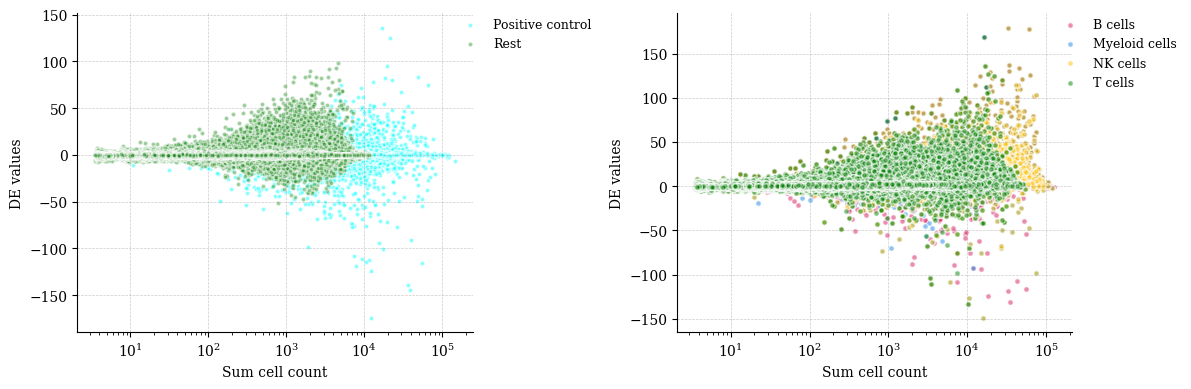

In [15]:
colors = [
    "#D81B60",  # Vivid pink
    "#1E88E5",  # Bright blue
    "#FFC107",  # Amber
    "green",  # Deep teal
    "cyan",  # Yellow
    "black",  # Deep purple
]
def plotMA(df_x, df_y, obs_index, x_label='', y_label='', log=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    for i_index, index in enumerate(obs_index):
        i = i_index // 2
        j = i_index % 2
        ax = axes[j]
        index_vars = df_x.index.get_level_values(index)
        if index=='sm_name':
            mask = (index_vars.isin(controls2))
            
            xs = df_x.loc[mask,:].values.flatten()
            ys = df_y.loc[mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[.1,.9])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Positive control', alpha=0.5, color='cyan', edgecolors='white', s=10)

            xs = df_x.loc[~mask,:].values.flatten()
            ys = df_y.loc[~mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[1,0])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Rest', alpha=0.4, color='green', edgecolors='white', s=10)
        else:
            included_vars = index_vars.unique()
            for i, var in enumerate(included_vars):
                color=colors[i]
                label = var
                mask = (index_vars == var)
                xs = df_x.loc[~mask,:].values.flatten()
                ys = df_y.loc[~mask,:].values.flatten()
                mask_top_quantile = ys > np.quantile(np.abs(ys), .95)
                np.random.seed(32)
                sparse_mask = np.random.choice([True, False], len(xs), p=[.05,.95])
                sparse_mask = sparse_mask | mask_top_quantile
                plt.scatter(xs[sparse_mask], ys[sparse_mask], label=var, alpha=.5, edgecolors='white', color=color, s=15)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        ax.spines[['right', 'top']].set_visible(False)
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(.95, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
plotMA(sum_count_genes, de_train, ['sm_name', 'cell_type'], x_label='Sum count', y_label='DE values', log=True)

## <a id='toc8_1_'></a>[Normality of the distribution](#toc0_)

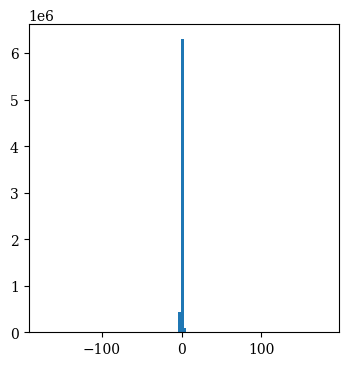

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=False)
data = de_train.values
aa = ax.hist(data.reshape(-1,1), bins=100)

## Variance 

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='std'>,
        <Axes: xlabel='Cell count', ylabel='std'>], dtype=object))

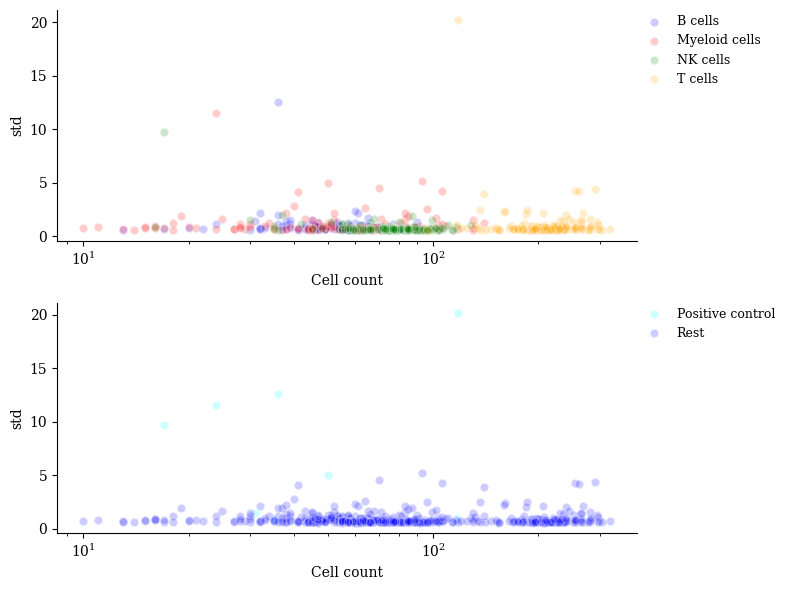

In [17]:
xs = cell_count.values
ys = std.values

plot_scatter(de_train.reset_index(), obs_index, xs, ys, x_label='Cell count', y_label='std', log=True, figsize=(8, 6))

## Positive values

In [18]:
plus_values.shape

(537,)

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='Proportion of positive values'>,
        <Axes: xlabel='Cell count', ylabel='Proportion of positive values'>],
       dtype=object))

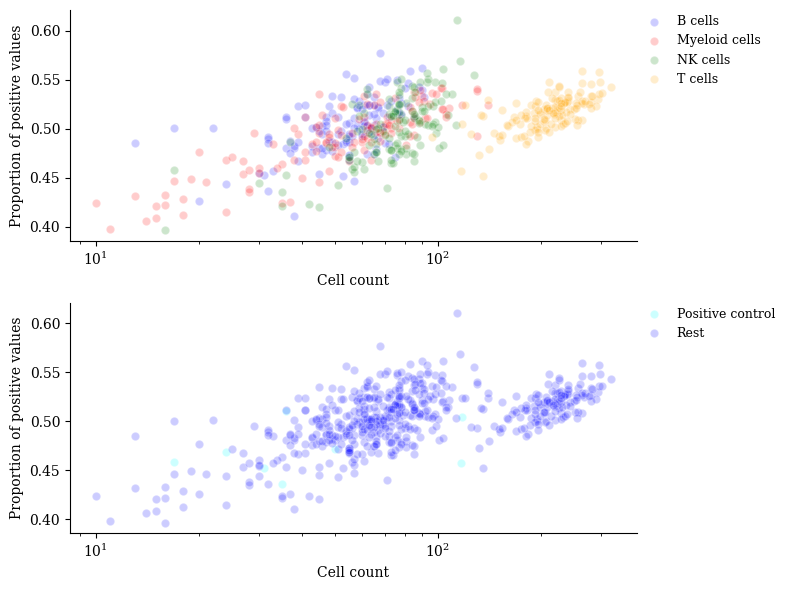

In [19]:
xs = cell_count.values
ys = plus_values

plot_scatter(de_train.reset_index(), obs_index, xs, ys, x_label='Cell count', y_label='Proportion of positive values', log=True, figsize=(8, 6))

## Fraction of sig genes

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='Fraction of sig genes'>,
        <Axes: xlabel='Cell count', ylabel='Fraction of sig genes'>],
       dtype=object))

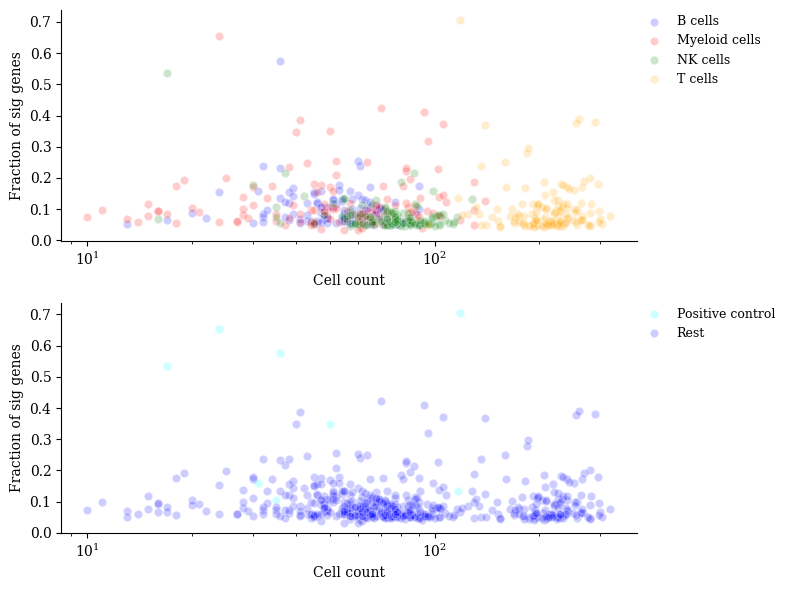

In [20]:
sig_ratio = np.sum(de_train_p < 0.05, axis=1)/de_train_p.shape[1]

xs = cell_count.values
ys = sig_ratio.values

plot_scatter(de_train.reset_index(), obs_index, xs, ys, x_label='Cell count', y_label='Fraction of sig genes', log=True, figsize=(8, 6))

## Low dimentional representation

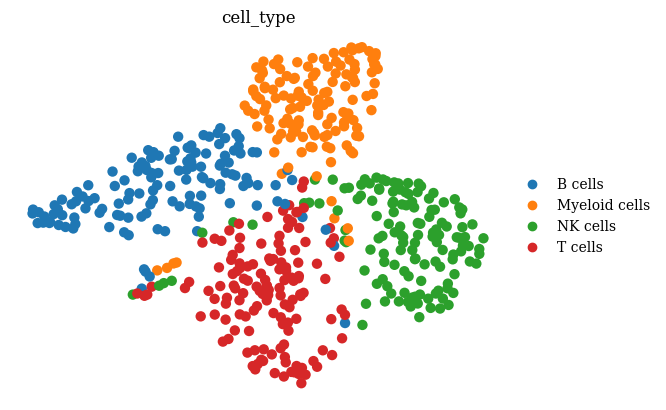

KeyError: 'Could not find key positive_control in .var_names or .obs.columns.'

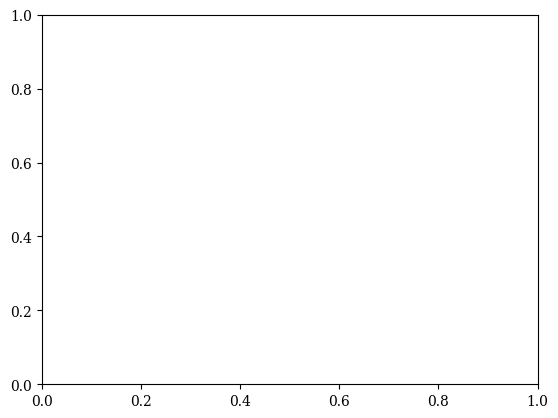

In [21]:
df = de_train
obs=df.index.to_frame().reset_index(drop=True)
var=pd.DataFrame(index=df.columns)
adata = ad.AnnData(X=df.values, obs=obs , var=var)
with warnings.catch_warnings():
    # custom_normalize(adata)
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type'], frameon=False)
    sc.pl.umap(adata, color=['positive_control'], frameon=False)

## Housekeeping genes

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
mask_hkgs = de_train.columns.isin(housekeeping_genes)
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
adata_ = bulk_adata_f[:, bulk_adata_f.var.index.isin(de_train.columns)]
adata_df = pd.DataFrame(adata_.X, index= pd.MultiIndex.from_frame(adata_.obs[bulk_index]), columns=adata_.var.index )
sum_count_genes = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train)
sig_mask = de_train_p<0.05

In [ ]:
sig_sum_genes = np.sum(de_train_p < 0.05, axis=0)
# sig_sum_genes[mask_hkgs].sum()/mask_hkgs.sum()
sig_sum_genes[~mask_hkgs].sum()/(~mask_hkgs).sum()

53.04658848614073

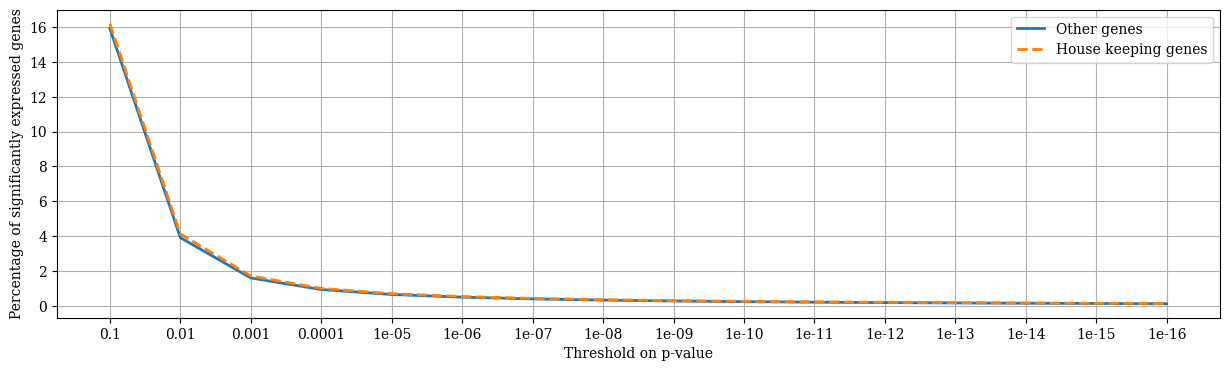

In [ ]:
import matplotlib.pyplot as plt


d = pd.DataFrame(); IX = -1
list_thresholds = [0.1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16]

data_df = de_train

for t in list_thresholds:
    # remaining all genes
    v  = data_df.loc[:, ~mask_hkgs].values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    IX+=1
    d.loc[IX, 'Threshold'] = t
    d.loc[IX, 'Other genes'] = 100*m.sum()/len(v)

    v  = data_df.loc[:, mask_hkgs].values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    d.loc[IX, 'House keeping genes'] = 100*m.sum()/len(v)

# Define line styles and line width
line_styles = ['-', '--', '-.', ':']
line_width = 2  # Increase the line thickness

plt.figure(figsize=(15, 4))

# Iterate over columns and line styles
for col, style in zip(d.columns[1:], line_styles * (len(d.columns) // len(line_styles) + 1)):
    plt.plot(d[col].values, label=col, linestyle=style, linewidth=line_width)

plt.grid()
plt.legend()
plt.xticks(range(len(list_thresholds)), list_thresholds)
plt.xlabel('Threshold on p-value')
plt.ylabel('Percentage of significantly expressed genes')
plt.savefig('sig.png', bbox_inches='tight')

plt.show()

In [ ]:
abs_diff = []
for t in list_thresholds:
    sig_sum = (de_train_p<t).sum(axis=0)
    hkgs_sum  = sig_sum[mask_hkgs].sum()/mask_hkgs.sum()
    rest_sum = sig_sum[~mask_hkgs].sum()/(~mask_hkgs).sum()


    abs_diff.append(rest_sum - hkgs_sum)
abs_diff

[-1.450045150166801,
 -1.1401403874224378,
 -0.626376765232985,
 -0.35524270890925536,
 -0.2431559399861718,
 -0.18652283263456582,
 -0.15932964911330627,
 -0.13619236112073163,
 -0.1172675144234947,
 -0.1145750657731508,
 -0.10657599270544593,
 -0.09870909564908548,
 -0.0791061778274269,
 -0.06979510514258502,
 -0.0633580263394864,
 -0.061620091257491905]

In [ ]:
std_for_genes.shape

(12766,)

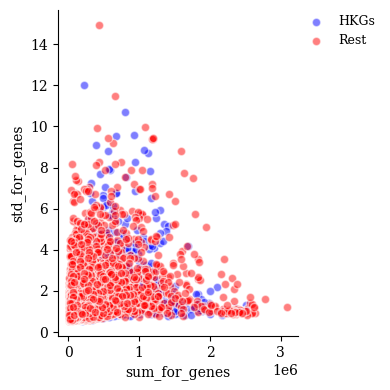

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=False)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']

ax.scatter(sum_for_genes[mask_hkgs], std_for_genes[mask_hkgs], label='HKGs', alpha=0.5, edgecolors='white', color=colors[0])
ax.scatter(sum_for_genes[~mask_hkgs], std_for_genes[~mask_hkgs], label='Rest', alpha=0.5, edgecolors='white', color=colors[1])
    
ax.set_xlabel('sum_for_genes')
ax.set_ylabel('std_for_genes')

ax.margins(0.05)
ax.spines[['right', 'top']].set_visible(False)
# ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'size': 9}
ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
#plt.axvline(x=25, linestyle='--', linewidth=1, color='black')
plt.tight_layout()


collection: original

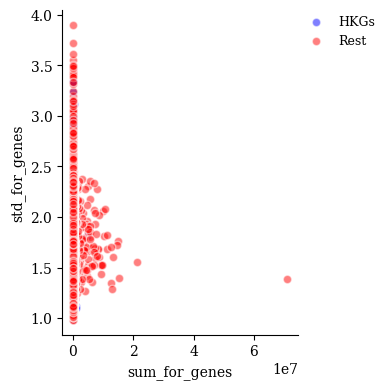